# INM430 - Tiny DS Project Progress Report

**Student Name:** Célia Detrez

**Project Title:** Predicting response times of the Paris Fire Brigade vehicles


**Questions:** 
- What influences the response times?
- Can response times be grouped in a significant way?
    - What is the difference between the groups?
    - What influences the response times of each group?

In [163]:
import io
from IPython.nbformat import current

references_count = 150

with io.open("C:\\Users\\Asus\\Documents\\City University\\INM430 Principles of Data Science\\Individual_coursework\\INM430ProjectReport-v2.ipynb", 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Number of words: ", word_count-references_count)

Number of words:  1462


## Packages

In [38]:
%matplotlib inline

# Some usual imports here

import contextily as ctx
from ipywidgets import interact
import csv as csv 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gp
import geoplot

import json
import geog
import shapely.geometry 

import scipy.stats as stats
from scipy.stats import spearmanr
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

import prince # [8]


plt.style.use("ggplot")
sns.set( style = "whitegrid" );

## Data pre-processing

### Main table

In [39]:
path = "C:\\Users\\Asus\\Documents\\City University\\INM430 Principles of Data Science\\Individual_coursework\\"

In [40]:
Index = "emergency vehicle selection" 

The Fire Brigade of Paris provides three different csv files with its intervention information [1]. These files are concatenated to carry the analysis out. 

In [41]:
x_data = pd.read_csv( path + "x.csv", index_col = 0, parse_dates = ["selection time", "date key sélection"] )
x_data_additional_file = pd.read_csv( path + "x_additional_file.csv", sep = ',', index_col = 0 )
Y_data = pd.read_csv( path + "y.csv", index_col = 0 ) 

In [42]:
data = pd.concat( [x_data,
                    x_data_additional_file,
                    Y_data],
                    axis = 1 )

In [43]:
del x_data, x_data_additional_file, Y_data #Save some memory space

*GPS tracks datetime departure-presentation* and *GPS tracks departure-presentation* columns contain all the successive positions information of the emergency vehicle. Only the first one is used as the routes have different length. 

In [44]:
data["GPS tracks departure-presentation"] = data["GPS tracks departure-presentation"].str.split(";", n = 1, expand = True)[0]
data["latitude departure"] = data["GPS tracks departure-presentation"].str.split(",", n = 1, expand = True )[0].astype("float")
data["longitude departure"] = data["GPS tracks departure-presentation"].str.split(",", n = 1, expand = True )[1].astype("float")

In [45]:
data["GPS tracks datetime departure-presentation"] = data["GPS tracks datetime departure-presentation"].str.split(";", n = 1, expand = True)[0]
data["departure time"] = data["GPS tracks datetime departure-presentation"].astype("datetime64[ns]")

To perform some time-related analysis, the date *departure time* has to be split into 5 different features: the day, the weekday, the season, the hour and the month.

In [46]:
data["day"] = data["departure time"].apply( lambda x: x.day ) 
data["weekday"] = data["departure time"].apply( lambda x: x.weekday( ) )
data["hour"] = data["departure time"].apply( lambda x: x.hour )
data["month"] = data["departure time"].apply( lambda x: x.month )
data["season"] = data["month"].apply( lambda x: ( x%12 + 3 )//3 )

data.month.replace({1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}, inplace = True )
data.season.replace({1:"Winter", 2:"Spring", 3:"Summer", 4:"Autumn"}, inplace = True )
data.weekday.replace({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}, inplace = True )

In [47]:
#Drop irrevelant columns
data.drop( columns = ["GPS tracks datetime departure-presentation",
                      "GPS tracks departure-presentation",
                      "OSRM response",
                      "OSRM estimate from last observed GPS position",
                      "selection time",
                      "date key sélection",
                      "time key sélection",
                      "departure time"],
          inplace = True )

### Weather information [2]

The monthly weather characteristics tables are loaded and concatenated in one main table. The day and the month features are created.

In [48]:
weather = pd.DataFrame()
for i in range(1,10):
    weather = pd.concat([pd.read_csv(path + "Meteo//"+"export-paris20180"+str(i)+".csv", sep =",", skiprows = 3, parse_dates =["DATE"]),weather],axis =0)
for i in range(10,13):
    weather = pd.concat([pd.read_csv(path + "Meteo//"+"export-paris2018"+str(i)+".csv", sep =",", skiprows = 3, parse_dates =["DATE"]),weather],axis =0)
weather.OPINION = (weather.OPINION=="météo défavorable").astype("int")

weather["day"] = weather["DATE"].apply( lambda x: x.day ) 
weather["month"] = weather["DATE"].apply( lambda x: x.month )
weather.month.replace({1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}, inplace = True )

weather.drop(columns = "DATE", inplace = True)

Contatenation with the main table

In [49]:
data = pd.merge(data,weather, on=["day",'month'])

### Space information

Three geospace tables are used to analyse to geographic influence over the response times [3,4,5,6].

In [50]:
IDF = gp.read_file(path + "departements_IDF.shp")
IDF = IDF.to_crs( epsg = 4326 )

paris = gp.read_file(path + "arrondissements.shp")
paris = paris.to_crs( epsg = 4326 )

In [51]:
#Extract from the json file the latitude and longitude
Bspp = pd.read_csv(path + "Bspp.csv", sep =";")[["x","y"]]  

Bspp.x = Bspp.x.str.replace(",",".").astype("float") 
Bspp.y = Bspp.y.str.replace(",",".").astype("float")


A new feature representing the intervention area of each fire brigade is generated from the latitude and the longitude of the fire stations.

In [52]:
for i in range(Bspp.shape[0]):
    p = shapely.geometry.Point([Bspp.loc[i,"x"], Bspp.loc[i,"y"]])
    n_points = 20
    d = 2000  # 2000 kilometers around the fire station
    angles = np.linspace(0, 360, n_points)
    polygon = geog.propagate(p, angles, d)
    Bspp.loc[i,"circle"] = shapely.geometry.shape(shapely.geometry.mapping(shapely.geometry.Polygon(polygon)))
Bspp = gp.GeoDataFrame(Bspp).set_geometry('circle')

In [53]:
Pop = gp.read_file(path +"Pop_IDF.shp")
Pop = Pop.to_crs( epsg = 4326 )

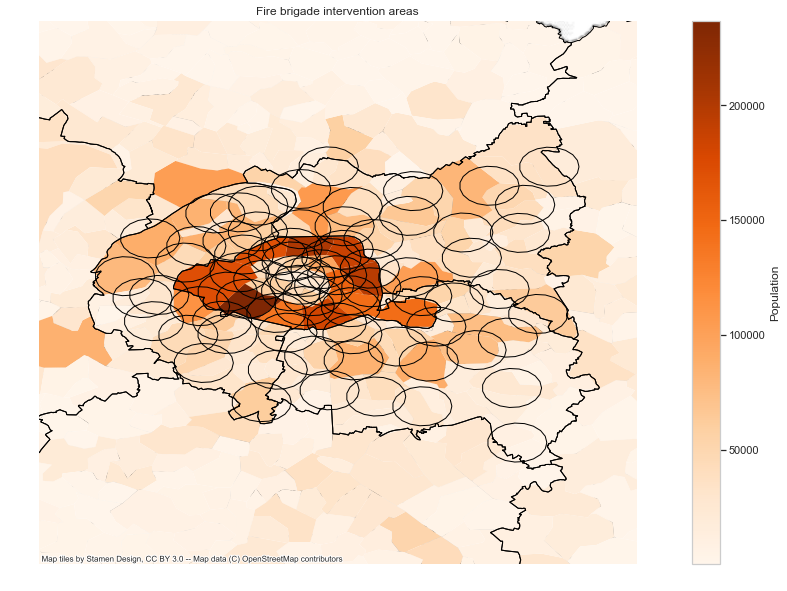

In [54]:
ax = Pop.plot( column = "popmun2010",
              cmap = "Oranges",
              edgecolor='None',
              figsize = (20, 10),
              legend = True,
              legend_kwds = {"label": "Population"})
IDF.plot( color = "None", edgecolor='black', ax = ax )
Bspp.plot( color = "None", edgecolor ="black", ax = ax, legend = True)

ctx.add_basemap(ax, crs = 4326, url=ctx.providers.Stamen.TonerLite )
plt.xlim((2.1,2.65))
plt.ylim((48.6,49.1))
plt.title( "Fire brigade intervention areas" )
plt.axis("off");

The areas overlap when the density of density increases. Hence, emergency services are supposed to arrive with about the same time. For this project, the assumption that the fire brigades work in an area with a 4 km diameter is made and only the location of the intervention is used to implement the models.

Outliers outside of IDF are ignored.


In [55]:
data = data[(data["latitude departure"]>IDF.geometry.bounds.minx.min()
            )&(data["latitude departure"]<IDF.geometry.bounds.maxx.max()
              )&(data["longitude departure"]>IDF.geometry.bounds.miny.min()
                )&(data["longitude departure"]<IDF.geometry.bounds.maxy.max())]

## Data preparation

### Missing values check

In [56]:
missing_values = data.isna( ).sum( )[data.isna( ).sum( ) > 0]/data.shape[0] * 100
pd.DataFrame( missing_values.sort_values(), columns = ["Percentage of missing values"] ) 

Percentage of missing values
OSRM estimated distance from last observed GPS ...                      0.066912
OSRM estimated duration from last observed GPS ...                      0.066912
updated OSRM estimated duration                                         0.066912
location of the event                                                   6.390097
delta position gps previous departure-departure                        92.680738

98% values of *delta position gps previous departure-departure* are missing, the choice has been made to delete this column. This column would have been useful to estimate the *delta selection-departure*. This project focuses on the *delta departure-presentation* analysis. For the features with approximately 70% of missing values, it is primordial to analyse closer the dataset.


In [57]:
data.drop(columns="delta position gps previous departure-departure", inplace = True)

### Size

In [58]:
print( "Number of samples:", data.shape[0] )
print( "Number of features:", data.shape[1])

Number of samples: 65758
Number of features: 53


The number of samples highlights a large dataset. The choice has been made to drop the samples with missing values.

In [59]:
data.dropna( inplace = True )

In [60]:
print( "Number of samples:", data.shape[0] )
print( "Number of features:", data.shape[1])

Number of samples: 61515
Number of features: 53


### Type

In [61]:
dic = {"intervention":"category",
       "floor":"category",
       "intervention on public roads":"category",
       "alert reason category":"category",
       "alert reason":"category",
       "emergency vehicle":"category",
       "emergency vehicle type":"category",
       "rescue center":"category",
       "status preceding selection" : "category",
       "location of the event" : "category",
       "departed from its rescue center":"category",
       "month":"category",
       "weekday":"category",
       "season":"category",
       "OPINION":"category",
       "WEATHER_CODE_NOON":"category",
       "WEATHER_CODE_MORNING":"category",
       "WEATHER_CODE_EVENING":"category",
       "UV_INDEX":"category"} #type of features

data = data.astype( dic )

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [62]:
types = pd.DataFrame( [len( data.select_dtypes(exclude=numerics).columns ),
                                  len( data.select_dtypes(include=numerics).columns )] ).T

types.rename( index = {0:"Number of features"}, columns = {0:"Categorical", 1:"Numerical"})

Categorical  Numerical
Number of features           19         34

### Numerical columns

> Correlation

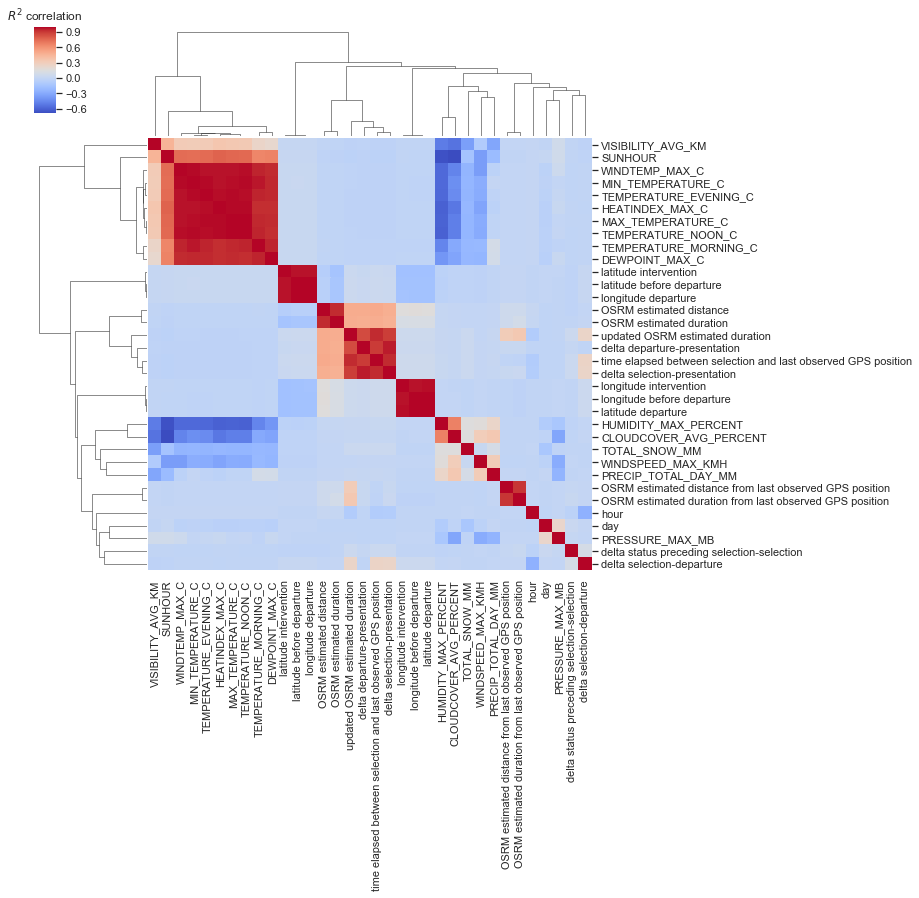

In [63]:
R2corr =  data.select_dtypes(include=numerics).corr( )

sns.clustermap( R2corr, cmap = "coolwarm" )
plt.title( "$R^2$ correlation" );

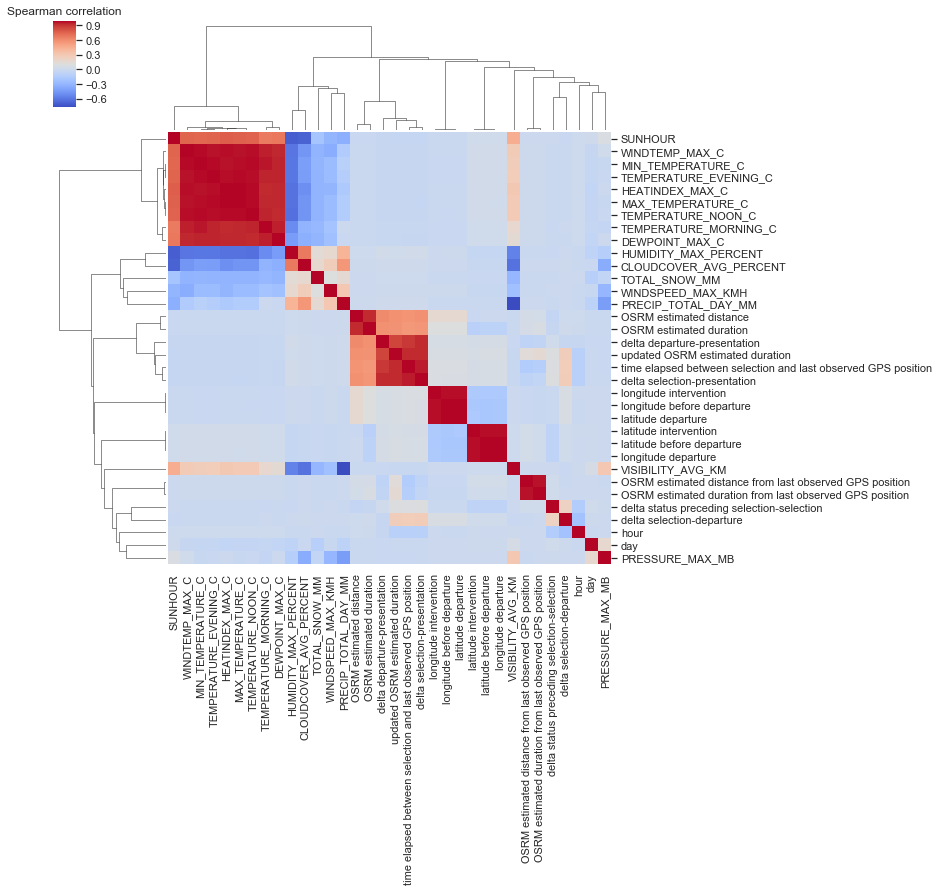

In [64]:
spearmancorr = pd.DataFrame( spearmanr(  data.select_dtypes(include=numerics) ).correlation )
spearmancorr.columns =  data.select_dtypes(include=numerics).columns
spearmancorr.index =  data.select_dtypes(include=numerics).columns

sns.clustermap( spearmancorr, cmap = "coolwarm" )
plt.title( "Spearman correlation" );

*delta departure-presentation* has a high $𝑅^2$ correlation of 0.96 with *delta selection-presentation*. Indeed, the relation between these two variables is linear: *delta departure-presentation* = *delta selection-presentation* - *delta selection-departure*. However, *delta selection-departure* has a low correlation of 0.26. Those two variables will not be used to create the models.

*delta departure-presentation* has also a high correlation of 0.94 with *time elapsed between selection and last observed GPS position*, and of 0.84 with *updated OSRM estimated duration*. Those variables will not be considered in the model as they provide the same information.

The $R^2$ correlation allows highlighting the linear relationship between features. Using the Spearman correlation, a non-parametric method with no distributional assumptions reinforces the previous statements and highlights that the *OSRM estimated distance* and *ORSM estimated duration* are also correlated to *delta departure-presentation* with a correlation of almost 0.6.

It also highlights the dependency between weather features. The *UV_INDEX* feature will be used for the models and the others (from the red group at the top) will be dropped. The latitude and longitude features will only be used for the visualisation.

In [65]:
data.drop(columns = ["TEMPERATURE_MORNING_C",
                     "DEWPOINT_MAX_C",
                     "MIN_TEMPERATURE_C",
                     "TEMPERATURE_EVENING_C",
                     "WINDTEMP_MAX_C",
                     "HEATINDEX_MAX_C",
                     'MAX_TEMPERATURE_C',
                     "TEMPERATURE_NOON_C"],
          inplace = True)

> Statistics

In [66]:
pd.DataFrame( [round( data.select_dtypes(include=numerics).mean( ), 2 ),
               round( data.select_dtypes(include=numerics).median( ), 2 ),
               round( data.select_dtypes(include=numerics).std( ), 2 ),
               pd.Series(stats.skew(data.select_dtypes(include=numerics) ),
                         index = data.select_dtypes(include=numerics).columns)] ,
             index = ['Mean', "Median", "Std", "Skew"]).T

Mean   Median  \
longitude intervention                                  2.37     2.37   
latitude intervention                                  48.85    48.86   
delta status preceding selection-selection          12977.88  3605.00   
longitude before departure                              2.38     2.37   
latitude before departure                              48.85    48.86   
OSRM estimated distance                              2380.70  2052.40   
OSRM estimated duration                               250.15   227.30   
OSRM estimated distance from last observed GPS ...    414.48   230.70   
OSRM estimated duration from last observed GPS ...     53.32    33.60   
time elapsed between selection and last observe...    454.70   421.71   
updated OSRM estimated duration                       508.02   472.09   
delta selection-departure                             132.13   124.00   
delta departure-presentation                          367.82   331.00   
delta selection-presentation                          499.95   465.00   
latitude departure                                      2.38     2.37   
longitude departure                                    48.85    48.86   
day                                                    15.53    15.00   
hour                                                   13.11    14.00   
WINDSPEED_MAX_KMH                                      15.99    15.00   
PRECIP_TOTAL_DAY_MM                                     1.14     0.10   
HUMIDITY_MAX_PERCENT                                   73.34    74.00   
VISIBILITY_AVG_KM                                       9.55    10.00   
PRESSURE_MAX_MB                                      1017.95  1018.00   
CLOUDCOVER_AVG_PERCENT                                 45.91    43.12   
TOTAL_SNOW_MM                                           0.04     0.00   
SUNHOUR                                                 9.76    10.10   

                                                         Std       Skew  
longitude intervention                                  0.09   0.032617  
latitude intervention                                   0.06  -0.088576  
delta status preceding selection-selection          37393.77  11.781490  
longitude before departure                              0.09   0.063039  
latitude before departure                               0.05  -0.098040  
OSRM estimated distance                              1490.67   1.655364  
OSRM estimated duration                               127.53   1.242062  
OSRM estimated distance from last observed GPS ...   1104.72  56.258874  
OSRM estimated duration from last observed GPS ...     79.61  20.560116  
time elapsed between selection and last observe...    210.07   5.719782  
updated OSRM estimated duration                       223.66   6.260139  
delta selection-departure                              58.44   5.942678  
delta departure-presentation                          213.73   8.815208  
delta selection-presentation                          221.06   8.309126  
latitude departure                                      0.09   0.054826  
longitude departure                                     0.05  -0.099812  
day                                                     8.77   0.056065  
hour                                                    6.35  -0.364969  
WINDSPEED_MAX_KMH                                       6.55   0.862810  
PRECIP_TOTAL_DAY_MM                                     2.28   3.564376  
HUMIDITY_MAX_PERCENT                                   13.47  -0.292057  
VISIBILITY_AVG_KM                                       0.87  -2.958435  
PRESSURE_MAX_MB                                         7.98  -0.390211  
CLOUDCOVER_AVG_PERCENT                                 28.61   0.116898  
TOTAL_SNOW_MM                                           0.32   9.797228  
SUNHOUR                                                 4.21  -0.094156

This table highlights some outliers that affect the mean and the variance. Deleting these outliers would not be useful to understand how the time between the departure and the presentation could be explained. 

> Distribution

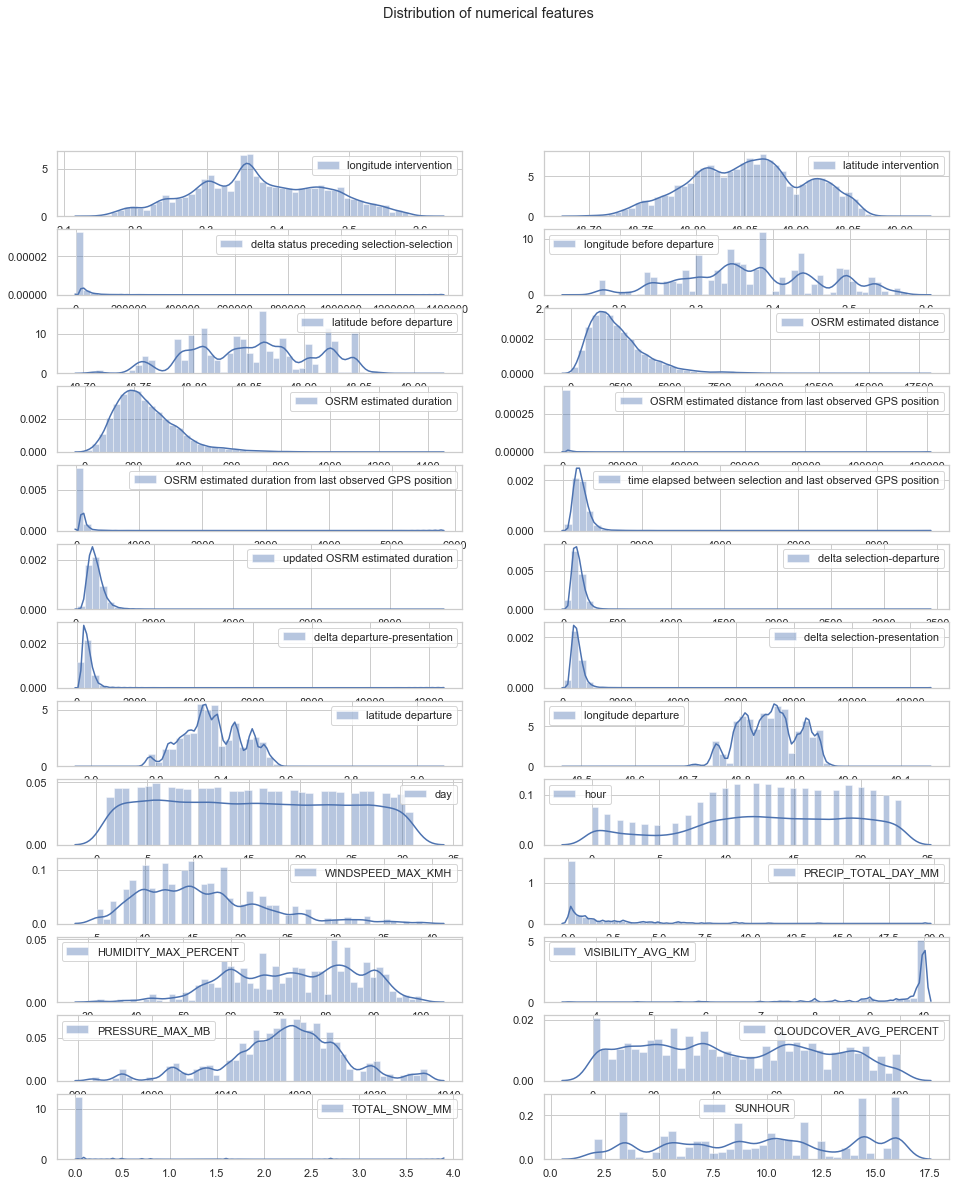

In [67]:
plt.figure( figsize = ( 16, 20 ) )
for i in range( len( data.select_dtypes(include=numerics).columns ) ):
    plt.subplot( len( data.select_dtypes(include=numerics).columns )//2 + 1, 2, i + 1 )
    sns.distplot( data.select_dtypes(include=numerics).iloc[:,i], label = data.select_dtypes(include=numerics).columns[i] )
    plt.legend( )
    plt.xlabel( "" )
plt.suptitle( "Distribution of numerical features" );

Some data science methods as Principal Components Analysis requires normally distributed data. Log transformation will be applied to the time elapsed between selection and last observed GPS position, delta- and OSRM- features in order to obtain normally distributed features. This transformation can only be implemented if there is not null values in the data.


In [68]:
print("Number of zeros:\n", ( data[[col for col in data.select_dtypes(include=numerics).columns if "OSRM" in col]+["time elapsed between selection and last observed GPS position", "delta departure-presentation", "delta status preceding selection-selection"]] == 0 ).sum( ) )

Number of zeros:
 OSRM estimated distance                                            0
OSRM estimated duration                                            0
OSRM estimated distance from last observed GPS position          130
OSRM estimated duration from last observed GPS position          331
updated OSRM estimated duration                                    0
time elapsed between selection and last observed GPS position      0
delta departure-presentation                                       0
delta status preceding selection-selection                         0
dtype: int64


In [69]:
col_log = ["OSRM estimated distance",
           "OSRM estimated duration",
           "updated OSRM estimated duration",
           "time elapsed between selection and last observed GPS position",
           "delta departure-presentation"]

data[[col for col in col_log]] = data[[col for col in col_log]].apply( np.log )

- One example of normal distribution: delta departure-presentation QQplot

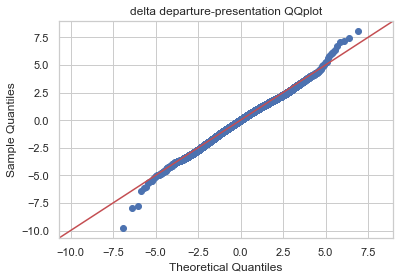

In [70]:
arr = np.array( data["delta departure-presentation"] )
normal = np.random.normal( loc = np.median( arr ), scale = arr.std( ), size = 1000 )
qqplot( arr, stats.t, fit = True, line = '45' )
plt.title( "delta departure-presentation QQplot" );

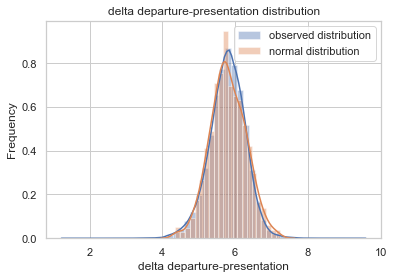

In [71]:
sns.distplot( arr, label = "observed distribution" );
sns.distplot( normal, label = "normal distribution" )
plt.title( "delta departure-presentation distribution" )
plt.ylabel( "Frequency" )
plt.xlabel( "delta departure-presentation" )
plt.legend( );

delta departure-presentation distribution is getting closer to a normal distribution thanks to the log transformation.

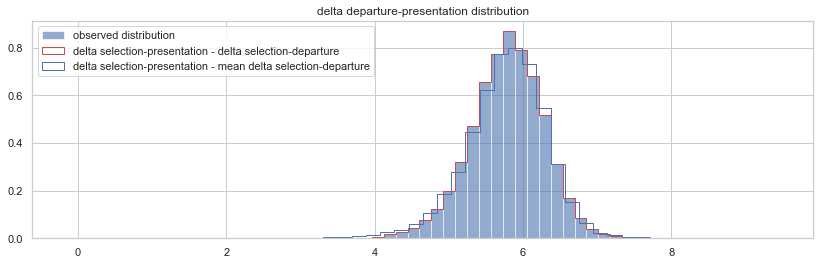

In [72]:
plt.figure( figsize = ( 14, 4 ) )
data["delta departure-presentation"].hist( bins = 50,
                                          density = True,
                                          alpha = 0.6,
                                          label = "observed distribution" )
( data["delta selection-presentation"] - data["delta selection-departure"] ).apply( np.log ).hist( bins = 50,
                                                                                                   density = True,
                                                                                                   alpha = 1,
                                                                                                   color = "r",
                                                                                                   histtype = 'step',
                                                                                                   label = "delta selection-presentation - delta selection-departure" )
( data["delta selection-presentation"] - data["delta selection-departure"].mean() ).apply( np.log ).hist( bins = 50,
                                                                                                   density = True,
                                                                                                   alpha = 1,
                                                                                                   color = "b",
                                                                                                   histtype = 'step',
                                                                                                   label = "delta selection-presentation - mean delta selection-departure" )
plt.title( "delta departure-presentation distribution" )
plt.legend();

The theoretical relationship between *delta selection-presentation*, *delta selection-departure* and, *delta departure-presentation* is verified. Moreover, *delta selection-departure* is negligible regarding *delta selection-presentation*. Attributing the mean of delta selection-departure could be a solution as it is proposed by the challenge to estimate the *delta selection-presentation* [1].

For the next steps, the analysis will focus on *delta departure-presentation*. Updated position features will not be considered as are highly dependent on the intervention and the time taken to go to the location of the event.


In [73]:
data.drop( columns = ["delta selection-presentation",
                      "delta selection-departure",
                      "updated OSRM estimated duration",
                      "OSRM estimated distance from last observed GPS position",
                      "OSRM estimated duration from last observed GPS position",
                      "time elapsed between selection and last observed GPS position"],
          inplace = True )

### Categorical columns 

In [74]:
categorical_columns = data.dtypes[data.dtypes=="category"].index

> Statistics

In [75]:
data[categorical_columns].describe()

intervention  alert reason category  alert reason  \
count          61515                  61515         61515   
unique         60688                      9           102   
top         13362005                      3          2162   
freq              11                  53551         21838   

        intervention on public roads  floor  location of the event  \
count                          61515  61515                61515.0   
unique                             2     37                  185.0   
top                                0      0                  139.0   
freq                           52764  39000                16086.0   

        emergency vehicle emergency vehicle type  rescue center  \
count               61515                  61515          61515   
unique                387                     20             72   
top                  5760              VSAV BSPP           2497   
freq                 1267                  51795           3637   

       status preceding selection  departed from its rescue center weekday  \
count                       61515                            61515   61515   
unique                          2                                2       7   
top                        Rentré                                1  Monday   
freq                        57054                            57054    9354   

        month  season  WEATHER_CODE_MORNING  WEATHER_CODE_NOON  \
count   61515   61515                 61515              61515   
unique     11       4                     7                  8   
top     March  Spring                   113                113   
freq     6216   17487                 24128              20995   

        WEATHER_CODE_EVENING  UV_INDEX  OPINION  
count                  61515     61515    61515  
unique                     6         7        2  
top                      113         2        0  
freq                   22804     16513    46353

*Intervention* has almost only unique values. It will not be considered. 

In [76]:
data.drop(columns = "intervention", inplace = True )

The features as *intervention on public roads* that have only two classes can easily be numerically transformed assigning 0 to one class and 1 to the other class. *alert reason category* is considered as an ordinal value and the same type of transformation can be applied.

For the others, one solution is to create dummies. It will significantly increase the number of features.


In [77]:
for c in ["intervention on public roads", "status preceding selection", "departed from its rescue center", "UV_INDEX"]:
    Label = LabelEncoder( )
    data[c] = Label.fit_transform( data[c] )
    data[c] = data[c].astype("object")

In [78]:
data_visual = data.copy()
data_visual["delta departure-presentation"]=data_visual["delta departure-presentation"].apply(np.exp)

In [79]:
for c in ["alert reason","emergency vehicle","emergency vehicle type","rescue center","location of the event","month","season","weekday"]:
    temp = pd.get_dummies(data[c], prefix =c, drop_first = False).astype("object")
    data.drop(columns = c, inplace = True)
    data = pd.concat([data, temp], axis =1)

## Feature dependency analysis

To understand the relation between the features and the delta departure-presentation some visualisations of the patterns can be used.

> Final data set

In [80]:
data.shape

(61515, 818)

###  Time of the intervention

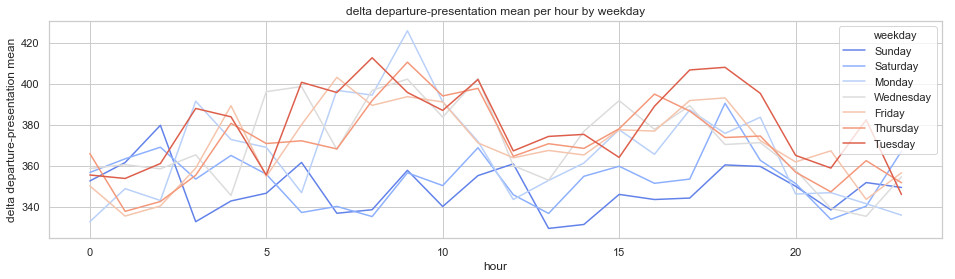

In [81]:
plt.figure( figsize = (16,4) )
sns.lineplot( x = "hour", y = "delta departure-presentation",
              data = data_visual.groupby( ["weekday", "hour"] )["delta departure-presentation"].mean( ).reset_index( ),
              hue = "weekday",
              hue_order = data_visual.groupby("weekday")["delta departure-presentation"].mean( ).sort_values( ).index,
              palette = sns.color_palette( "coolwarm", 7 ))
plt.ylabel( "delta departure-presentation mean" )
plt.title("delta departure-presentation mean per hour by weekday");

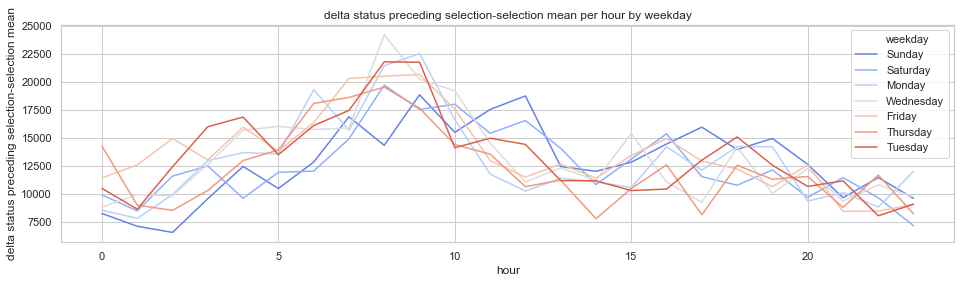

In [82]:
plt.figure( figsize = (16,4) )
sns.lineplot( x = "hour", y = "delta status preceding selection-selection",
              data = data_visual.groupby( ["weekday", "hour"] )["delta status preceding selection-selection"].mean( ).reset_index( ),
              hue = "weekday",
              hue_order = data_visual.groupby("weekday")["delta departure-presentation"].mean( ).sort_values( ).index,
              palette = sns.color_palette( "coolwarm", 7 ))
plt.ylabel( "delta status preceding selection-selection mean" )
plt.title("delta status preceding selection-selection mean per hour by weekday");

During the working days and peak hours, the delta departure-presentation is higher than during the weekend. 

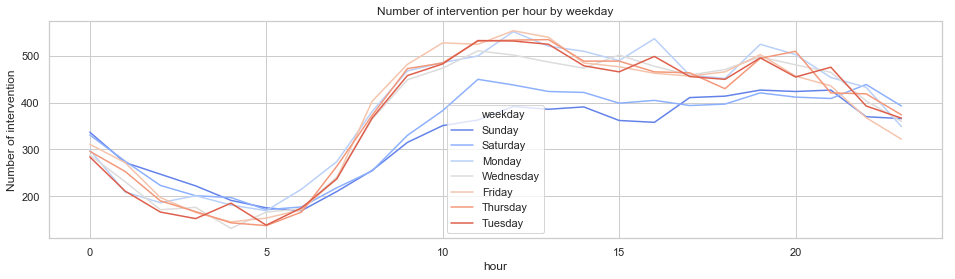

In [84]:
plt.figure( figsize = (16,4) )
sns.lineplot( x = "hour", y = 0,
              data = data_visual.groupby( ["weekday", "hour"] ).size( ).reset_index( ),
              hue = "weekday",
              hue_order = data_visual.groupby("weekday")["delta departure-presentation"].mean( ).sort_values( ).index,
              palette = sns.color_palette( "coolwarm", 7 ))
plt.ylabel( "Number of intervention" )
plt.title("Number of intervention per hour by weekday");

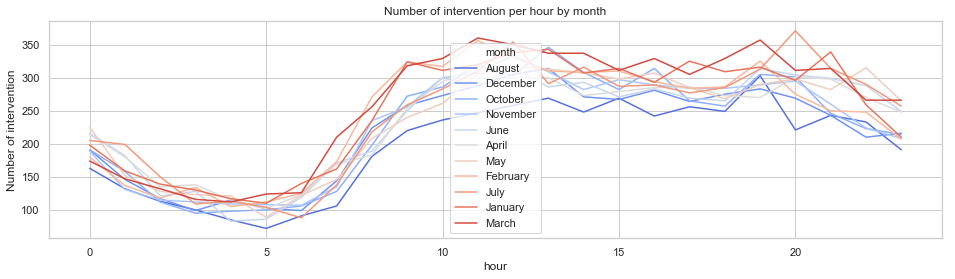

In [85]:
plt.figure( figsize = (16,4) )
sns.lineplot( x = "hour", y = 0,
              data = data_visual.groupby( ["hour", "month"] ).size( ).reset_index( ),
              hue = "month",
              hue_order = data_visual.groupby("month").size( ).sort_values( ).index,
              palette = sns.color_palette( "coolwarm", 11 ))
plt.ylabel( "Number of intervention" )
plt.title("Number of intervention per hour by month");

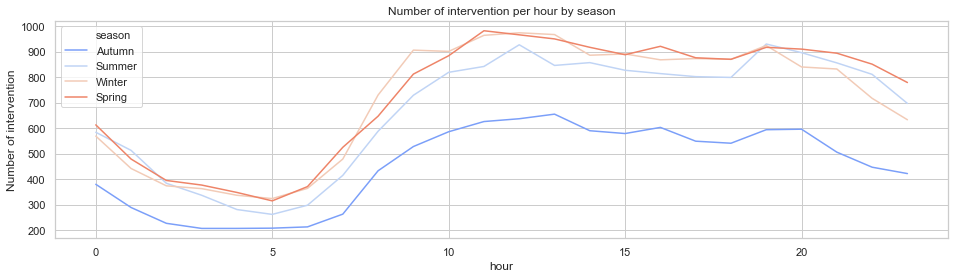

In [86]:
plt.figure( figsize = (16,4) )
sns.lineplot( x = "hour", y = 0,
              data = data_visual.groupby( ["hour", "season"] ).size( ).reset_index( ),
              hue = "season",
              hue_order = data_visual.groupby("season").size( ).sort_values( ).index,
              palette = sns.color_palette( "coolwarm", 4 ))
plt.ylabel( "Number of intervention" )
plt.title("Number of intervention per hour by season");

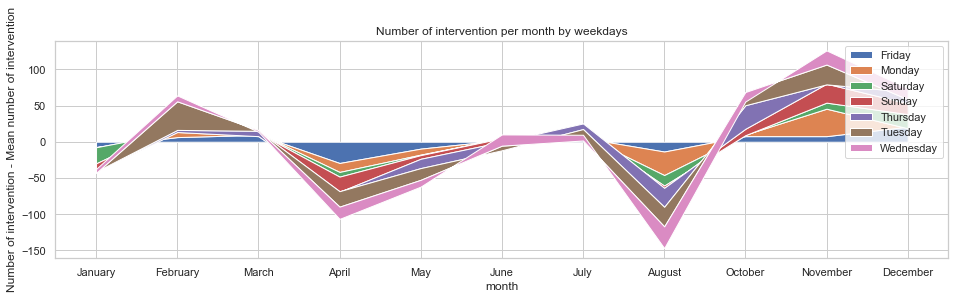

In [87]:
data_stack = data_visual.groupby( ["weekday", "month"] )["delta departure-presentation"].mean( ).unstack( "weekday" )
data_stack = data_stack.transform(lambda x : x-x.mean()).loc[["January","February","March","April","May","June","July","August","October","November","December"]]
plt.figure(figsize = (16,4))
plt.stackplot( data_stack.index, data_stack.T )
plt.legend( data_stack.columns )
plt.xlabel( "month" )
plt.ylabel( "Number of intervention - Mean number of intervention" )
plt.title("Number of intervention per month by weekdays");

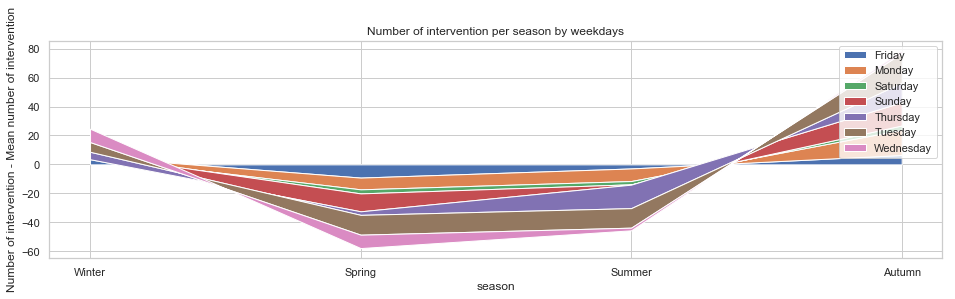

In [88]:
data_stack = data_visual.groupby( ["weekday", "season"] )["delta departure-presentation"].mean( ).unstack( "weekday" )
data_stack = data_stack.transform(lambda x : x-x.mean()).loc[["Winter", "Spring", "Summer","Autumn"]]
plt.figure(figsize = (16,4))
plt.stackplot( data_stack.index, data_stack.T )
plt.legend( data_stack.columns )
plt.xlabel( "season" )
plt.ylabel( "Number of intervention - Mean number of intervention" )
plt.title("Number of intervention per season by weekdays");

Whatever the weekday or the month, from 8pm to 5pm the number of interventions slightly goes down and increases from 6am. It reaches an asymptote around 12pm. Moreover, most interventions happen during working days.

During the winter and the spring, the number of interventions is more important especially during heatwave and cold spell months.


### Characteristics of the intervention

#### Reasons and locations of the interventions

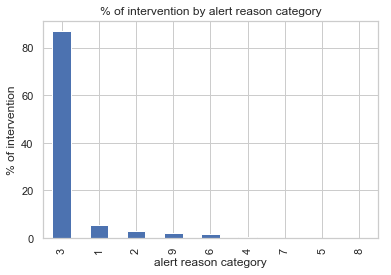

In [51]:
( data.groupby(["alert reason category"]).size()/data.shape[0]*100 ).sort_values(ascending = False).plot.bar(y=0)
plt.ylabel( "Percentage of intervention" )
plt.title("Percentage of intervention by alert reason category");

The most common reasons are 3, 1 and 2. It seems that the numbers are in order of importance.


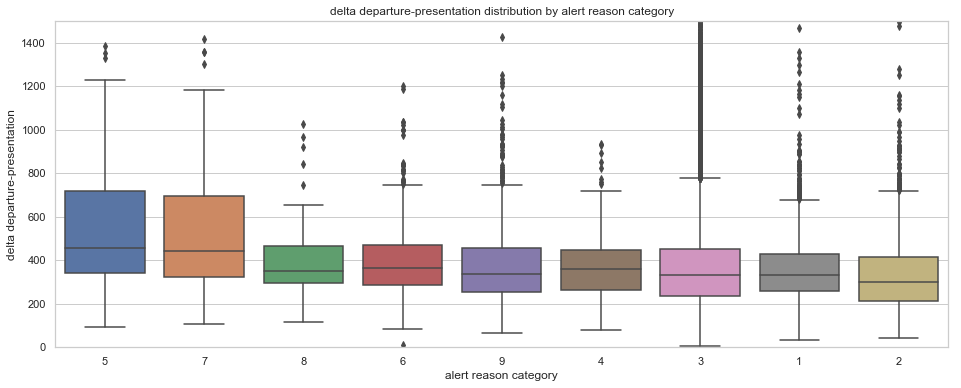

In [52]:
plt.figure( figsize = (16,6) )
sns.boxplot( x = "alert reason category", y = "delta departure-presentation", data = data_visual, order = data_visual.groupby( "alert reason category" )["delta departure-presentation"].mean( ).sort_values( ascending = False ).index )
plt.ylim( ( 0, 1500 ) )
plt.title("delta departure-presentation distribution by alert reason category");

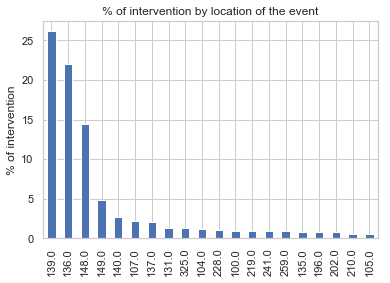

In [53]:
(data_visual["location of the event" ].value_counts()/data_visual["location of the event" ].shape[0]*100 ).sort_values(ascending = False)[:20].plot.bar(y=0)
plt.ylabel( "Percentage of intervention" )
plt.title("Percentage of intervention by location of the event");

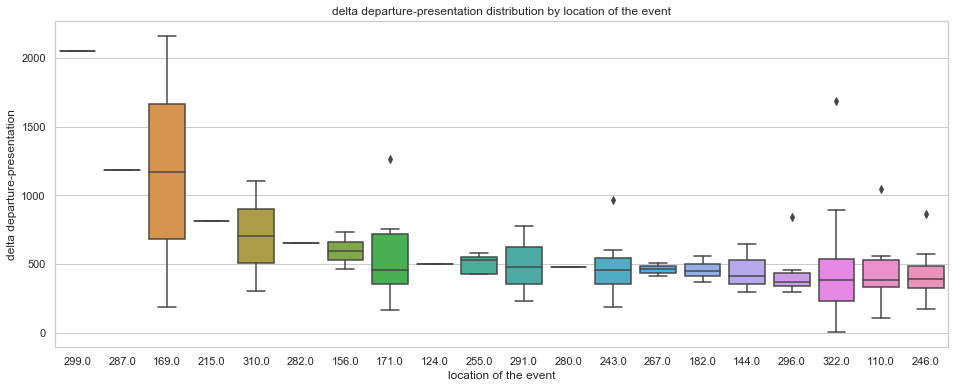

In [54]:
plt.figure( figsize = (16,6) )
sns.boxplot( x = "location of the event", y = "delta departure-presentation", data = data_visual, order = data_visual.groupby( "location of the event" )["delta departure-presentation"].mean( ).sort_values( ascending = False ).index[:20] )
plt.title("delta departure-presentation distribution by location of the event");

#### Vehicle for the intervention

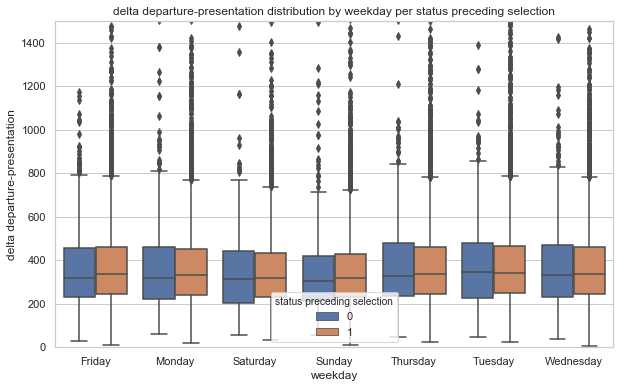

In [55]:
plt.figure( figsize = (10,6) )
sns.boxplot( x = "weekday", y = "delta departure-presentation", hue = "status preceding selection", data = data_visual )
plt.ylim( ( 0, 1500 ) )
plt.title("delta departure-presentation distribution by weekday per status preceding selection");

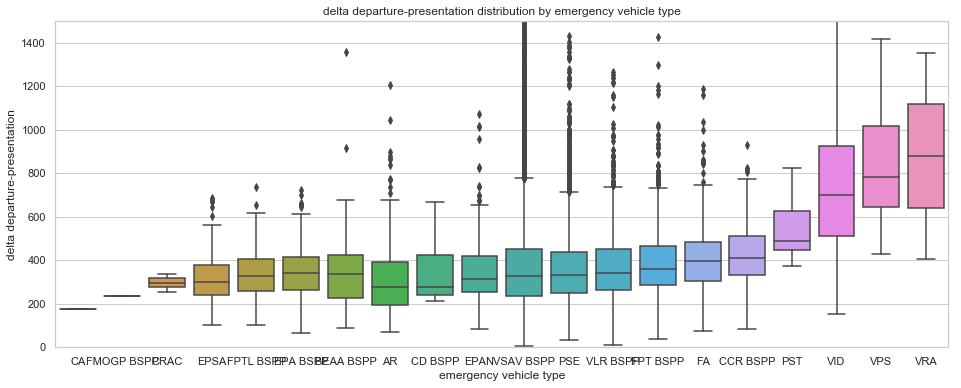

In [56]:
plt.figure( figsize = (16,6) )
sns.boxplot( x = "emergency vehicle type",
             y = "delta departure-presentation",
             data = data_visual,
             order = data_visual.groupby( "emergency vehicle type" )["delta departure-presentation"].mean( ).sort_values( ).index )
plt.ylim( ( 0, 1500 ) )
plt.title("delta departure-presentation distribution by emergency vehicle type");

The *type of vehicle* for the intervention influences the *delta departure-presentation* as a some vehicles are specific for one type of intervention [7].

In [57]:
data_emergency_vehicle = data_visual.groupby( ["emergency vehicle type", "alert reason category"] ).size()

In [58]:
data_emergency_vehicle.unstack(0).idxmax(1).replace({"PSE":"First Aid vehicles", "VSAV BSPP":"Aid and victims help vehicles", "VID":"Diverse interventions vehicles"})

alert reason category
1                First Aid vehicles
2     Aid and victims help vehicles
3     Aid and victims help vehicles
4                First Aid vehicles
5    Diverse interventions vehicles
6                          VLR BSPP
7    Diverse interventions vehicles
8                          VLR BSPP
9                First Aid vehicles
dtype: object

### Weather

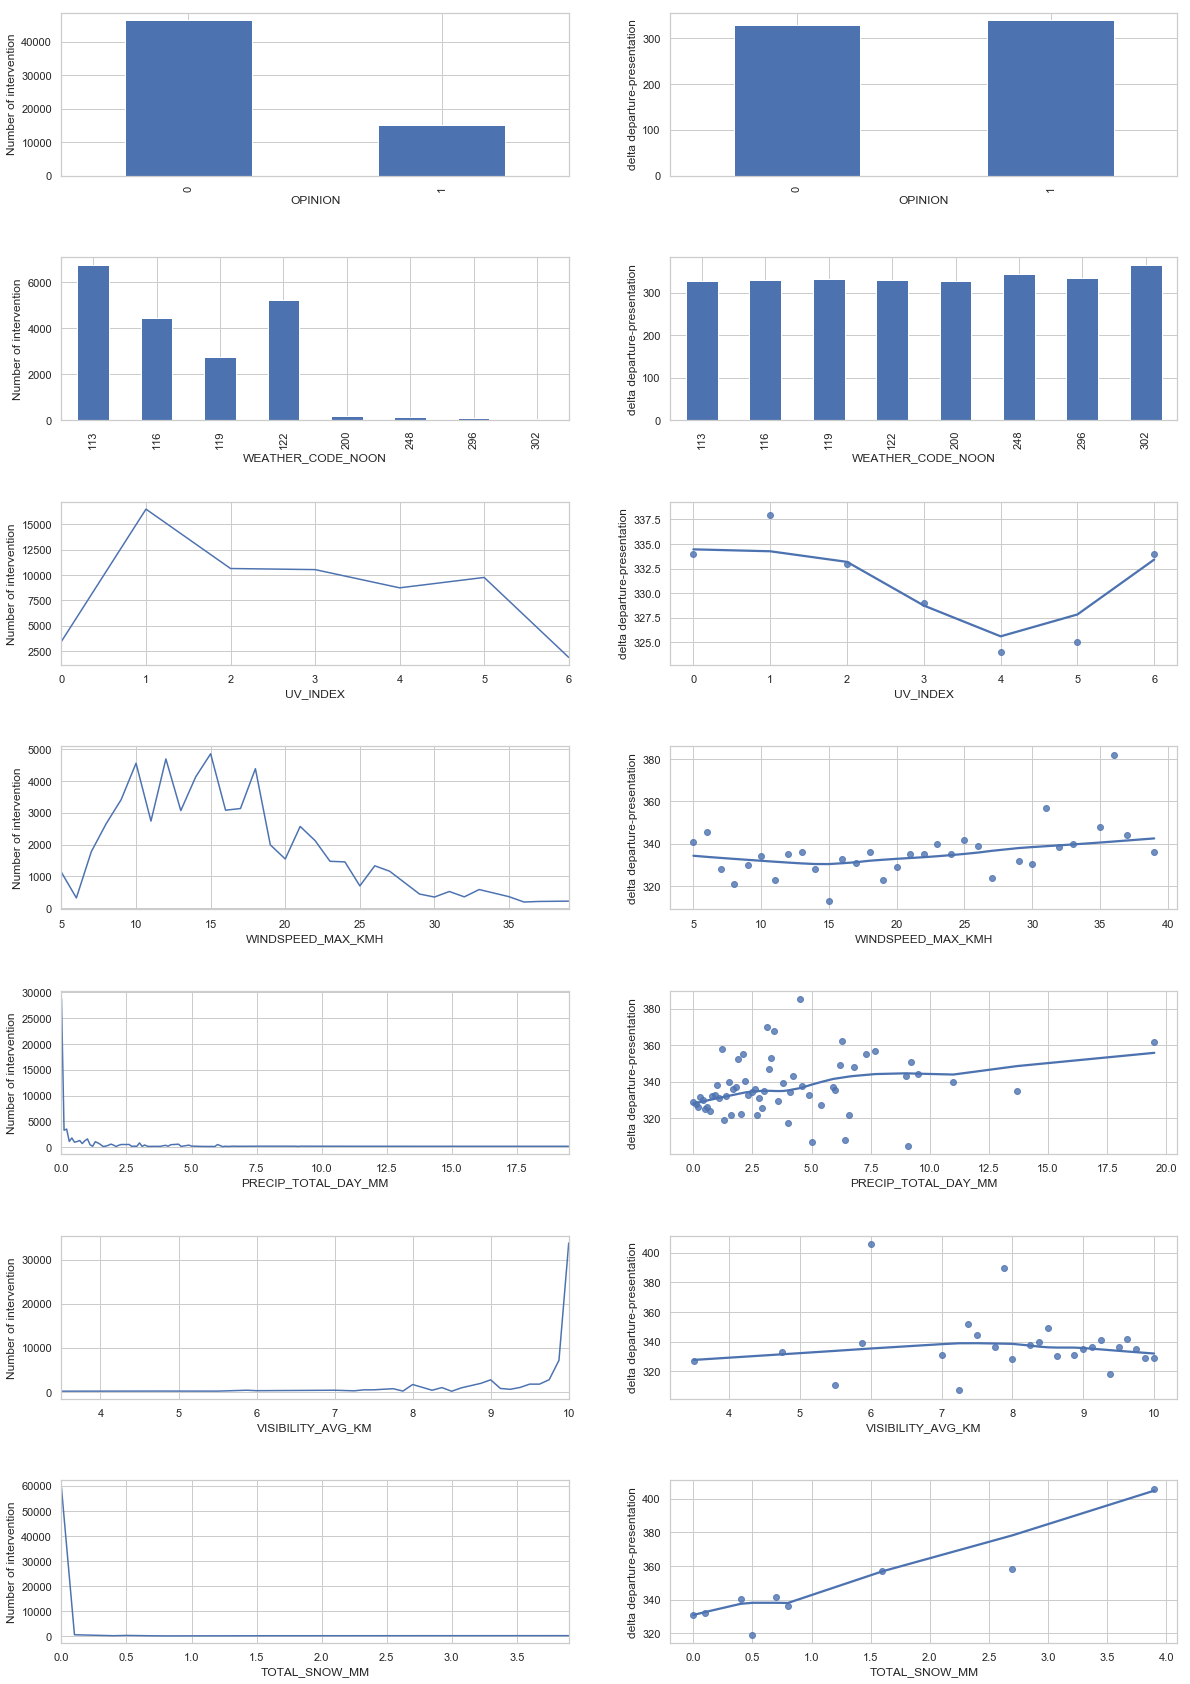

In [59]:
plt.figure(figsize = (20,30))
plt.subplot(7,2,1)
data_visual.groupby("OPINION").size().plot.bar();
plt.ylabel("Number of intervention")

plt.subplot(7,2,2)
data_visual.groupby("OPINION")["delta departure-presentation"].median().plot.bar();
plt.ylabel("delta departure-presentation")
plt.subplot(7,2,3)
data_visual[data_visual.hour.isin([12,
                                   13,
                                   14,
                                   15,
                                   16,
                                   18])].groupby("WEATHER_CODE_NOON").size().plot.bar();
plt.ylabel("Number of intervention")
plt.subplot(7,2,4)
data_visual[data_visual.hour.isin([12,
                                   13,
                                   14,
                                   15,
                                   16,
                                   18])].groupby("WEATHER_CODE_NOON")["delta departure-presentation"].median().plot.bar();
plt.ylabel("delta departure-presentation")

plt.subplot(7,2,5)
data.groupby("UV_INDEX").size().plot()
plt.ylabel("Number of intervention")

plt.subplot(7,2,6)
plot = data_visual.groupby("UV_INDEX")["delta departure-presentation"].median().reset_index()
sns.regplot(x ="UV_INDEX", y = "delta departure-presentation", data = plot.astype("float"), lowess = True);
plt.ylabel("delta departure-presentation")

plt.subplot(7,2,7)
data_visual.groupby("WINDSPEED_MAX_KMH").size().plot();
plt.ylabel("Number of intervention")

plt.subplot(7,2,8)
plot = data_visual.groupby("WINDSPEED_MAX_KMH")["delta departure-presentation"].median().reset_index()
sns.regplot(x = "WINDSPEED_MAX_KMH", y = "delta departure-presentation", data = plot, lowess = True);
plt.ylabel("delta departure-presentation")

plt.subplot(7,2,9)
data_visual.groupby("PRECIP_TOTAL_DAY_MM").size().plot();
plt.ylabel("Number of intervention")
plt.subplot(7,2,10)
plot = data_visual.groupby("PRECIP_TOTAL_DAY_MM")["delta departure-presentation"].median().reset_index()
sns.regplot(x = "PRECIP_TOTAL_DAY_MM", y = "delta departure-presentation", data = plot, lowess =  True );

plt.subplot(7,2,11)
data_visual.groupby("VISIBILITY_AVG_KM").size().plot();
plt.ylabel("Number of intervention")
plt.subplot(7,2,12)
plot = data_visual.groupby("VISIBILITY_AVG_KM")["delta departure-presentation"].median().reset_index()
sns.regplot(x = "VISIBILITY_AVG_KM", y = "delta departure-presentation", data = plot, lowess =  True );

plt.subplot(7,2,13)
data_visual.groupby("TOTAL_SNOW_MM").size().plot();
plt.ylabel("Number of intervention")
plt.subplot(7,2,14)
plot = data_visual.groupby("TOTAL_SNOW_MM")["delta departure-presentation"].median().reset_index()
sns.regplot(x = "TOTAL_SNOW_MM", y = "delta departure-presentation", data = plot, lowess =  True );


plt.subplots_adjust(wspace =0.2, hspace = 0.5)

Emergency vehicles take more time during "bad" weather day than during "good" weather day.

## Computational modelling

### Feature derivation

#### Groups of delta departure-presentation

To answer the second question of this project, the samples have to be clustered. Firstly, groups of *delta departure-presentation* are created by splitting the response times into 3 groups with the same time windows to help clustering techniques. 

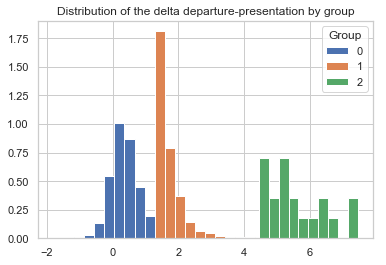

In [95]:
data["delta departure-presentation_rat"] = data.apply(lambda x : x.loc["delta departure-presentation"]-x.loc["OSRM estimated duration"], axis =1)
data["delta departure-presentation_cat"] = pd.cut(data["delta departure-presentation_rat"], bins = 3, labels = False)

data.groupby("delta departure-presentation_cat")["delta departure-presentation_rat"].hist(density = True)
plt.title("Distribution of the delta departure-presentation by group")
plt.legend([0, 1, 2], title = "Group");

In [96]:
pd.DataFrame(data.groupby(["delta departure-presentation_cat"]).size()).rename(columns = {0:"Number of samples"})

Number of samples
delta departure-presentation_cat                   
0                                             58827
1                                              2669
2                                                19

In [97]:
#Define a unique colormap for all the visualisation of the groups
palette = dict(zip([0,1,2,3],["blue","red","green"])) 

In [98]:
@interact
def show_hour(day=data_visual.weekday.sort_values().unique(), hour=data_visual.hour.sort_values().unique()):
    
    ax = IDF.plot( color = "None", edgecolor='black', figsize = (20, 10) )
    paris.plot( color = "None", edgecolor='black', ax = ax )
    Bspp.plot( color = "None", edgecolor ="grey", ax = ax)
    plot = data[(data.hour == hour) & (data["weekday_"+day]==1)]
    
    y = list(zip(plot["latitude before departure"], plot["latitude intervention"]))
    x = list(zip(plot["longitude before departure"], plot["longitude intervention"]))
    
    for i in range(0, len(x), 1):
        plt.plot(x[i], y[i], color = palette[plot.iloc[i,:]["delta departure-presentation_cat"]])
    
    plt.xlim((2.1,2.65))
    plt.ylim((48.6,49.1))
    plt.title( "Emergency response times" )
    plt.axis("off");

interactive(children=(Dropdown(description='day', options=('Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday…

This interactive map allows visualising the different groups over time and space. The line represents the routes of emergency vehicles. The assumption that the fire brigades work in an area with a 4 kilometers diameter is verified. Hence, only the latitude and the longitude of the intervention will be considered in the model.

In [171]:
model_columns = data.drop(columns = ["delta departure-presentation_cat",
                                     "delta departure-presentation",
                                     "delta departure-presentation_rat",
                                     "latitude departure",
                                     "longitude departure",
                                     "latitude before departure",
                                     "longitude before departure"]).columns

#### Feature reduction

As the data set has a large number of 818 features, reduction techniques could allow identifying the clusters.

##### LDA

Linear Discriminant Analysis (LDA) allows reducing the dimensionality of numerical features taking into account the categorical feature *delta departure-presentation_cat*. It assumes that [10]:
- numerical variables are normally distributed for each group.

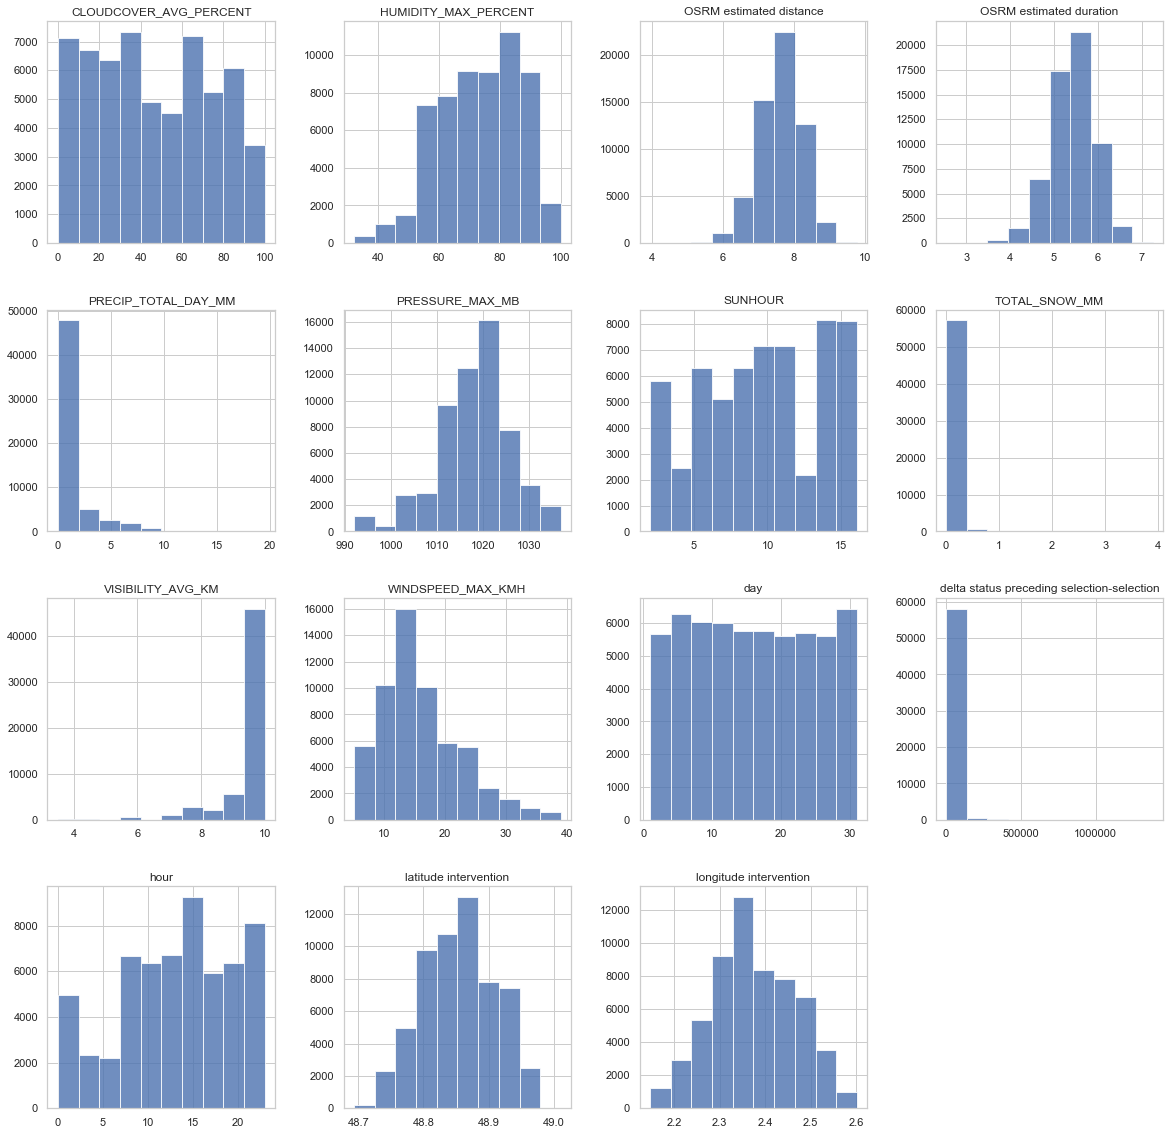

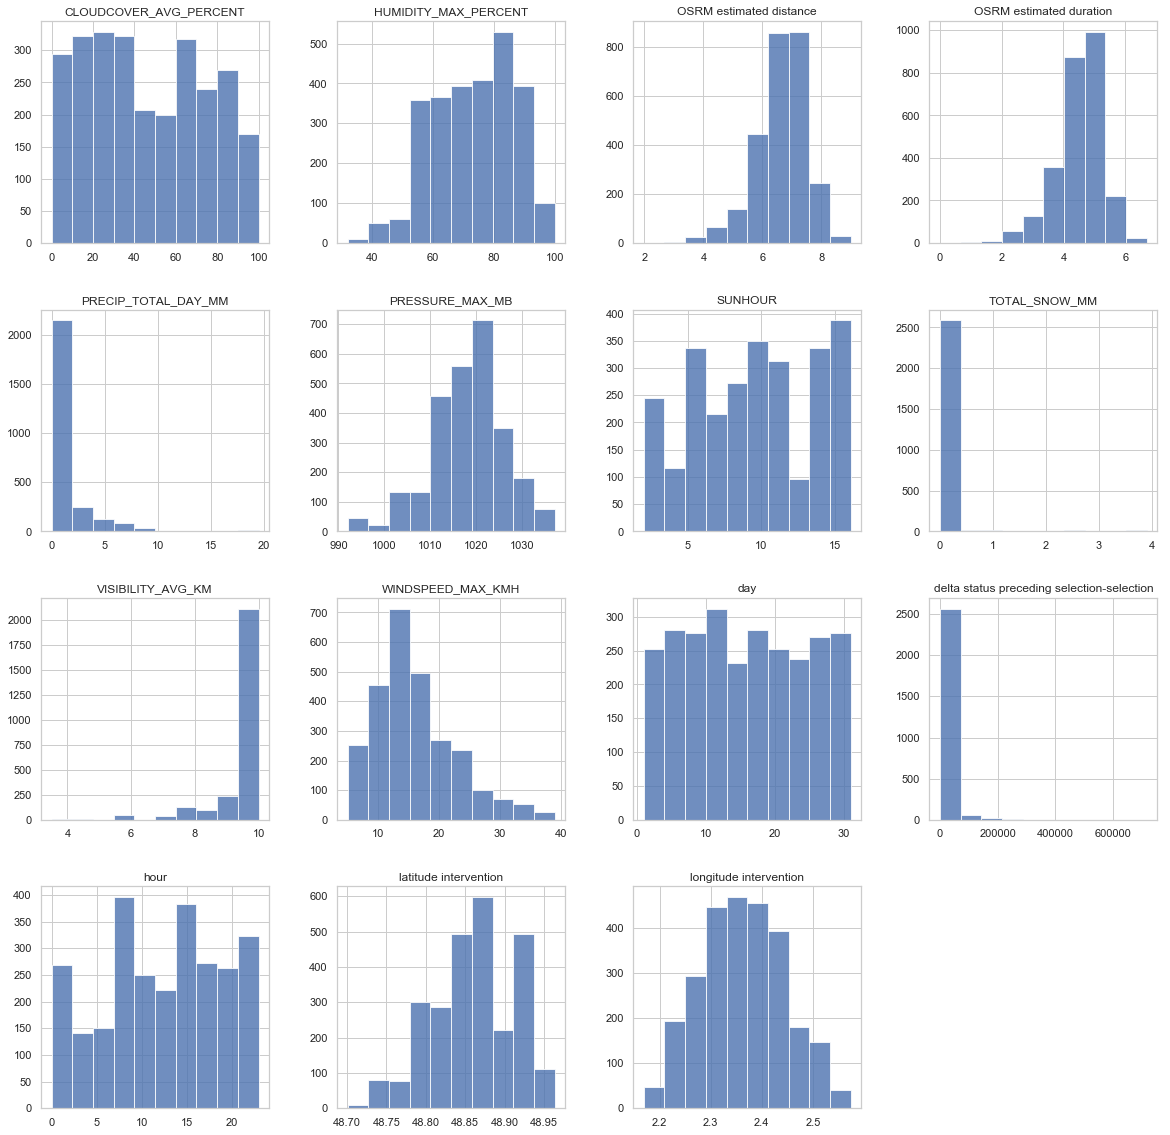

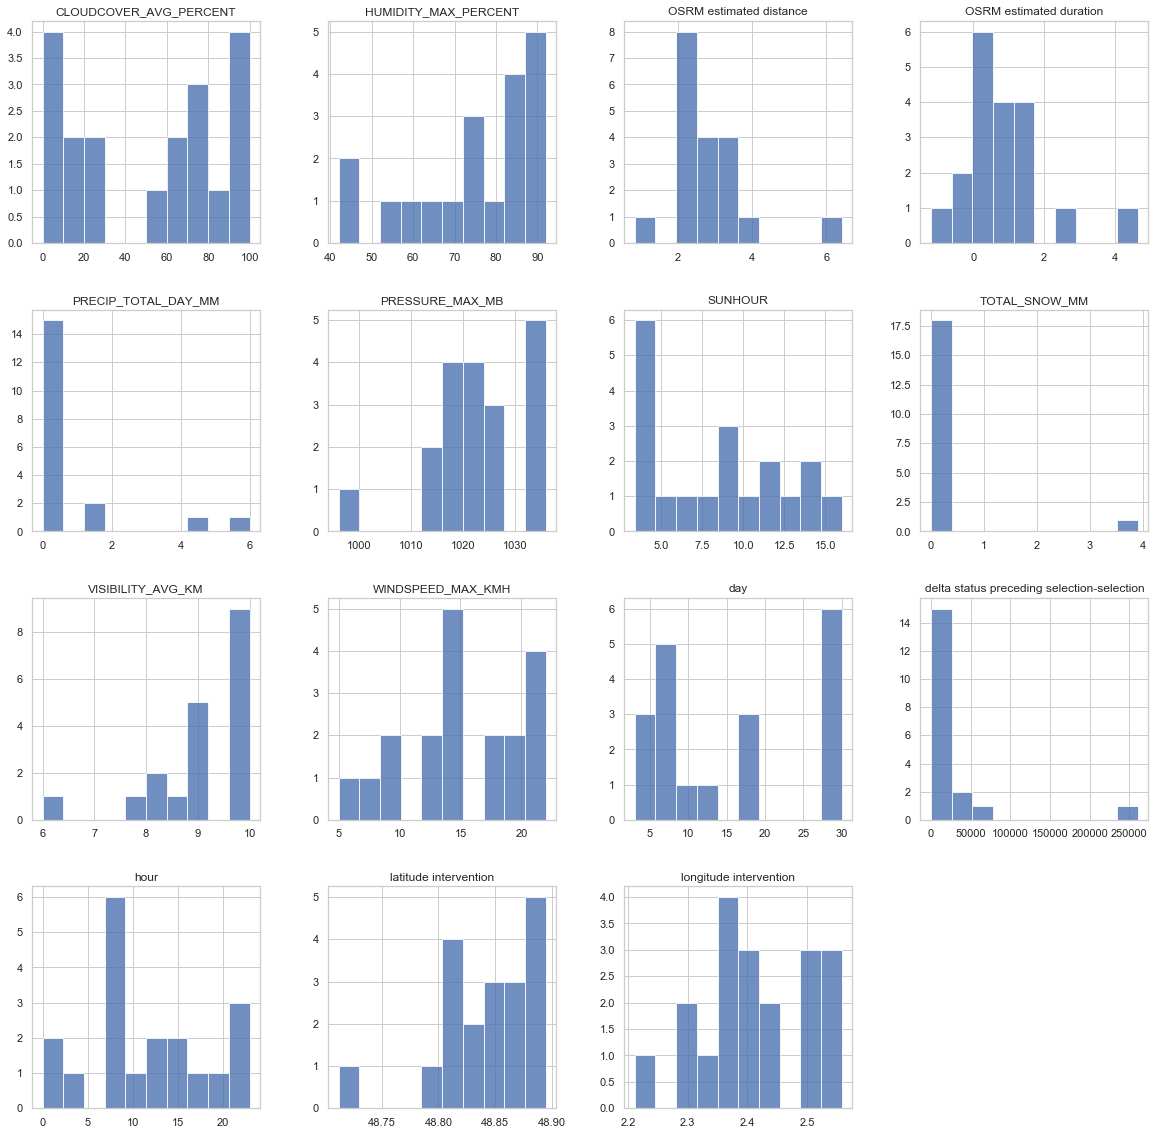

In [100]:
d = pd.concat([data[model_columns].select_dtypes(include=numerics),data["delta departure-presentation_cat"]], axis = 1)
d.groupby("delta departure-presentation_cat").hist(alpha = 0.8, figsize = (20,20));

- variances among group variables are the same across levels of predictors.

In [101]:
d.groupby("delta departure-presentation_cat").var()

longitude intervention  \
delta departure-presentation_cat                           
0                                               0.008401   
1                                               0.006634   
2                                               0.008617   

                                  latitude intervention  \
delta departure-presentation_cat                          
0                                              0.003052   
1                                              0.002681   
2                                              0.001940   

                                  delta status preceding selection-selection  \
delta departure-presentation_cat                                               
0                                                               1.396541e+09   
1                                                               1.419346e+09   
2                                                               3.591864e+09   

                                  OSRM estimated distance  \
delta departure-presentation_cat                            
0                                                0.362700   
1                                                0.733299   
2                                                1.180086   

                                  OSRM estimated duration         day  \
delta departure-presentation_cat                                        
0                                                0.246882   76.981278   
1                                                0.575084   76.243591   
2                                                1.455444  109.035088   

                                       hour  WINDSPEED_MAX_KMH  \
delta departure-presentation_cat                                 
0                                 40.119678          42.894872   
1                                 43.053243          43.168073   
2                                 49.538012          23.695906   

                                  PRECIP_TOTAL_DAY_MM  HUMIDITY_MAX_PERCENT  \
delta departure-presentation_cat                                              
0                                            5.184716            181.481910   
1                                            5.548916            180.974880   
2                                            2.686667            252.672515   

                                  VISIBILITY_AVG_KM  PRESSURE_MAX_MB  \
delta departure-presentation_cat                                       
0                                          0.751659        63.757115   
1                                          0.794679        62.817918   
2                                          1.191795       101.479532   

                                  CLOUDCOVER_AVG_PERCENT  TOTAL_SNOW_MM  \
delta departure-presentation_cat                                          
0                                             817.998256       0.100032   
1                                             822.930522       0.171221   
2                                            1429.246254       0.800526   

                                    SUNHOUR  
delta departure-presentation_cat             
0                                 17.750428  
1                                 17.788925  
2                                 18.167602

- there is low multicollinearity between the variables.
- the samples are independent.

In [102]:
#Normalise the data 
x_lda = normalize(data[model_columns].select_dtypes(include=numerics))

In [103]:
lda = LDA(n_components = 2)
x_lda = lda.fit_transform(x_lda, data["delta departure-presentation_cat"])

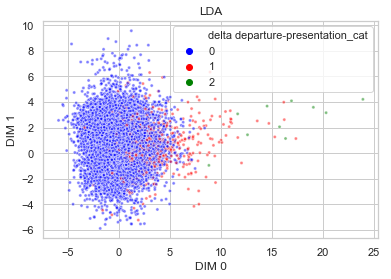

In [104]:
sns.scatterplot(x=x_lda[:,0], y = x_lda[:,1], hue =data["delta departure-presentation_cat"], palette ={0:"blue",1:"red",2:"green"}, alpha = 0.5, s=10 )
plt.xlabel("DIM 0")
plt.ylabel("DIM 1")
plt.title("LDA");

In [105]:
lda.explained_variance_ratio_

array([0.99304119, 0.00695881])

In [106]:
data["lda_0"]=x_lda[:,0]  #Save the results
data["lda_1"]=x_lda[:,1]

In [107]:
del x_lda, lda

##### PCA

Principal components analysis (PCA) allows to reduce the dimensionality of numerical features but it is not using the categorical feature *delta departure-presentation_cat*. It assumes that some features are correlated and linearly related. 

In [73]:
#Normalise the data 
x_pca = normalize(data[model_columns].select_dtypes(include=numerics))

In [74]:
pca = PCA(n_components = 10)
pca.fit(x_pca)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

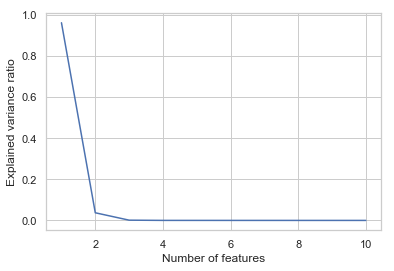

In [75]:
plt.plot(range(1,11),pca.explained_variance_ratio_)
plt.xlabel("Number of features")
plt.ylabel("Explained variance ratio");

According to the elbow method, the best number of components for PCA is 2.

In [76]:
x_pca = PCA(n_components = 2).fit_transform(x_pca)

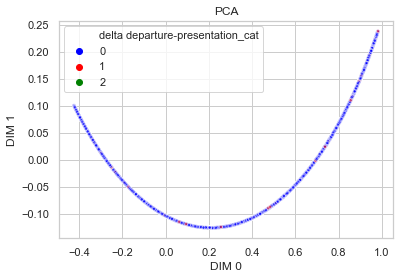

In [77]:
sns.scatterplot(x=x_pca[:,0], y = x_pca[:,1], hue =data["delta departure-presentation_cat"], palette ={0:"blue",1:"red",2:"green"}, alpha = 0.5, s=10 )
plt.xlabel("DIM 0")
plt.ylabel("DIM 1")
plt.title("PCA");

PCA reduction doesn't allow visualising the different groups. Hence, PCA will not be used.

In [78]:
data["pca_0"]= x_pca[:,0]
data["pca_1"]=x_pca[:,1]

In [79]:
del x_pca, pca

##### MCA

Multiple correspondence analysis (MCA) allows to reduce the dimensionality of categorical features but it is not using the categorical feature *delta departure-presentation_cat*. It requires no assumption.


In [108]:
mca = prince.MCA(n_components=20,
...     n_iter=10)
mca.fit(data[model_columns].select_dtypes(exclude=numerics))

MCA(check_input=True, copy=True, engine='auto', n_components=20, n_iter=10,
    random_state=None)

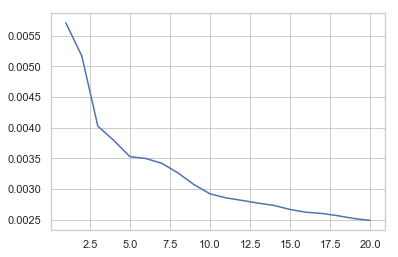

In [109]:
plt.plot(range(1,21),mca.explained_inertia_);

According to the elbow method, the best number of components for MCA is 10.

In [110]:
x_mca = prince.MCA(n_components=10,
...     n_iter=10).fit_transform(data[model_columns].select_dtypes(exclude=numerics))

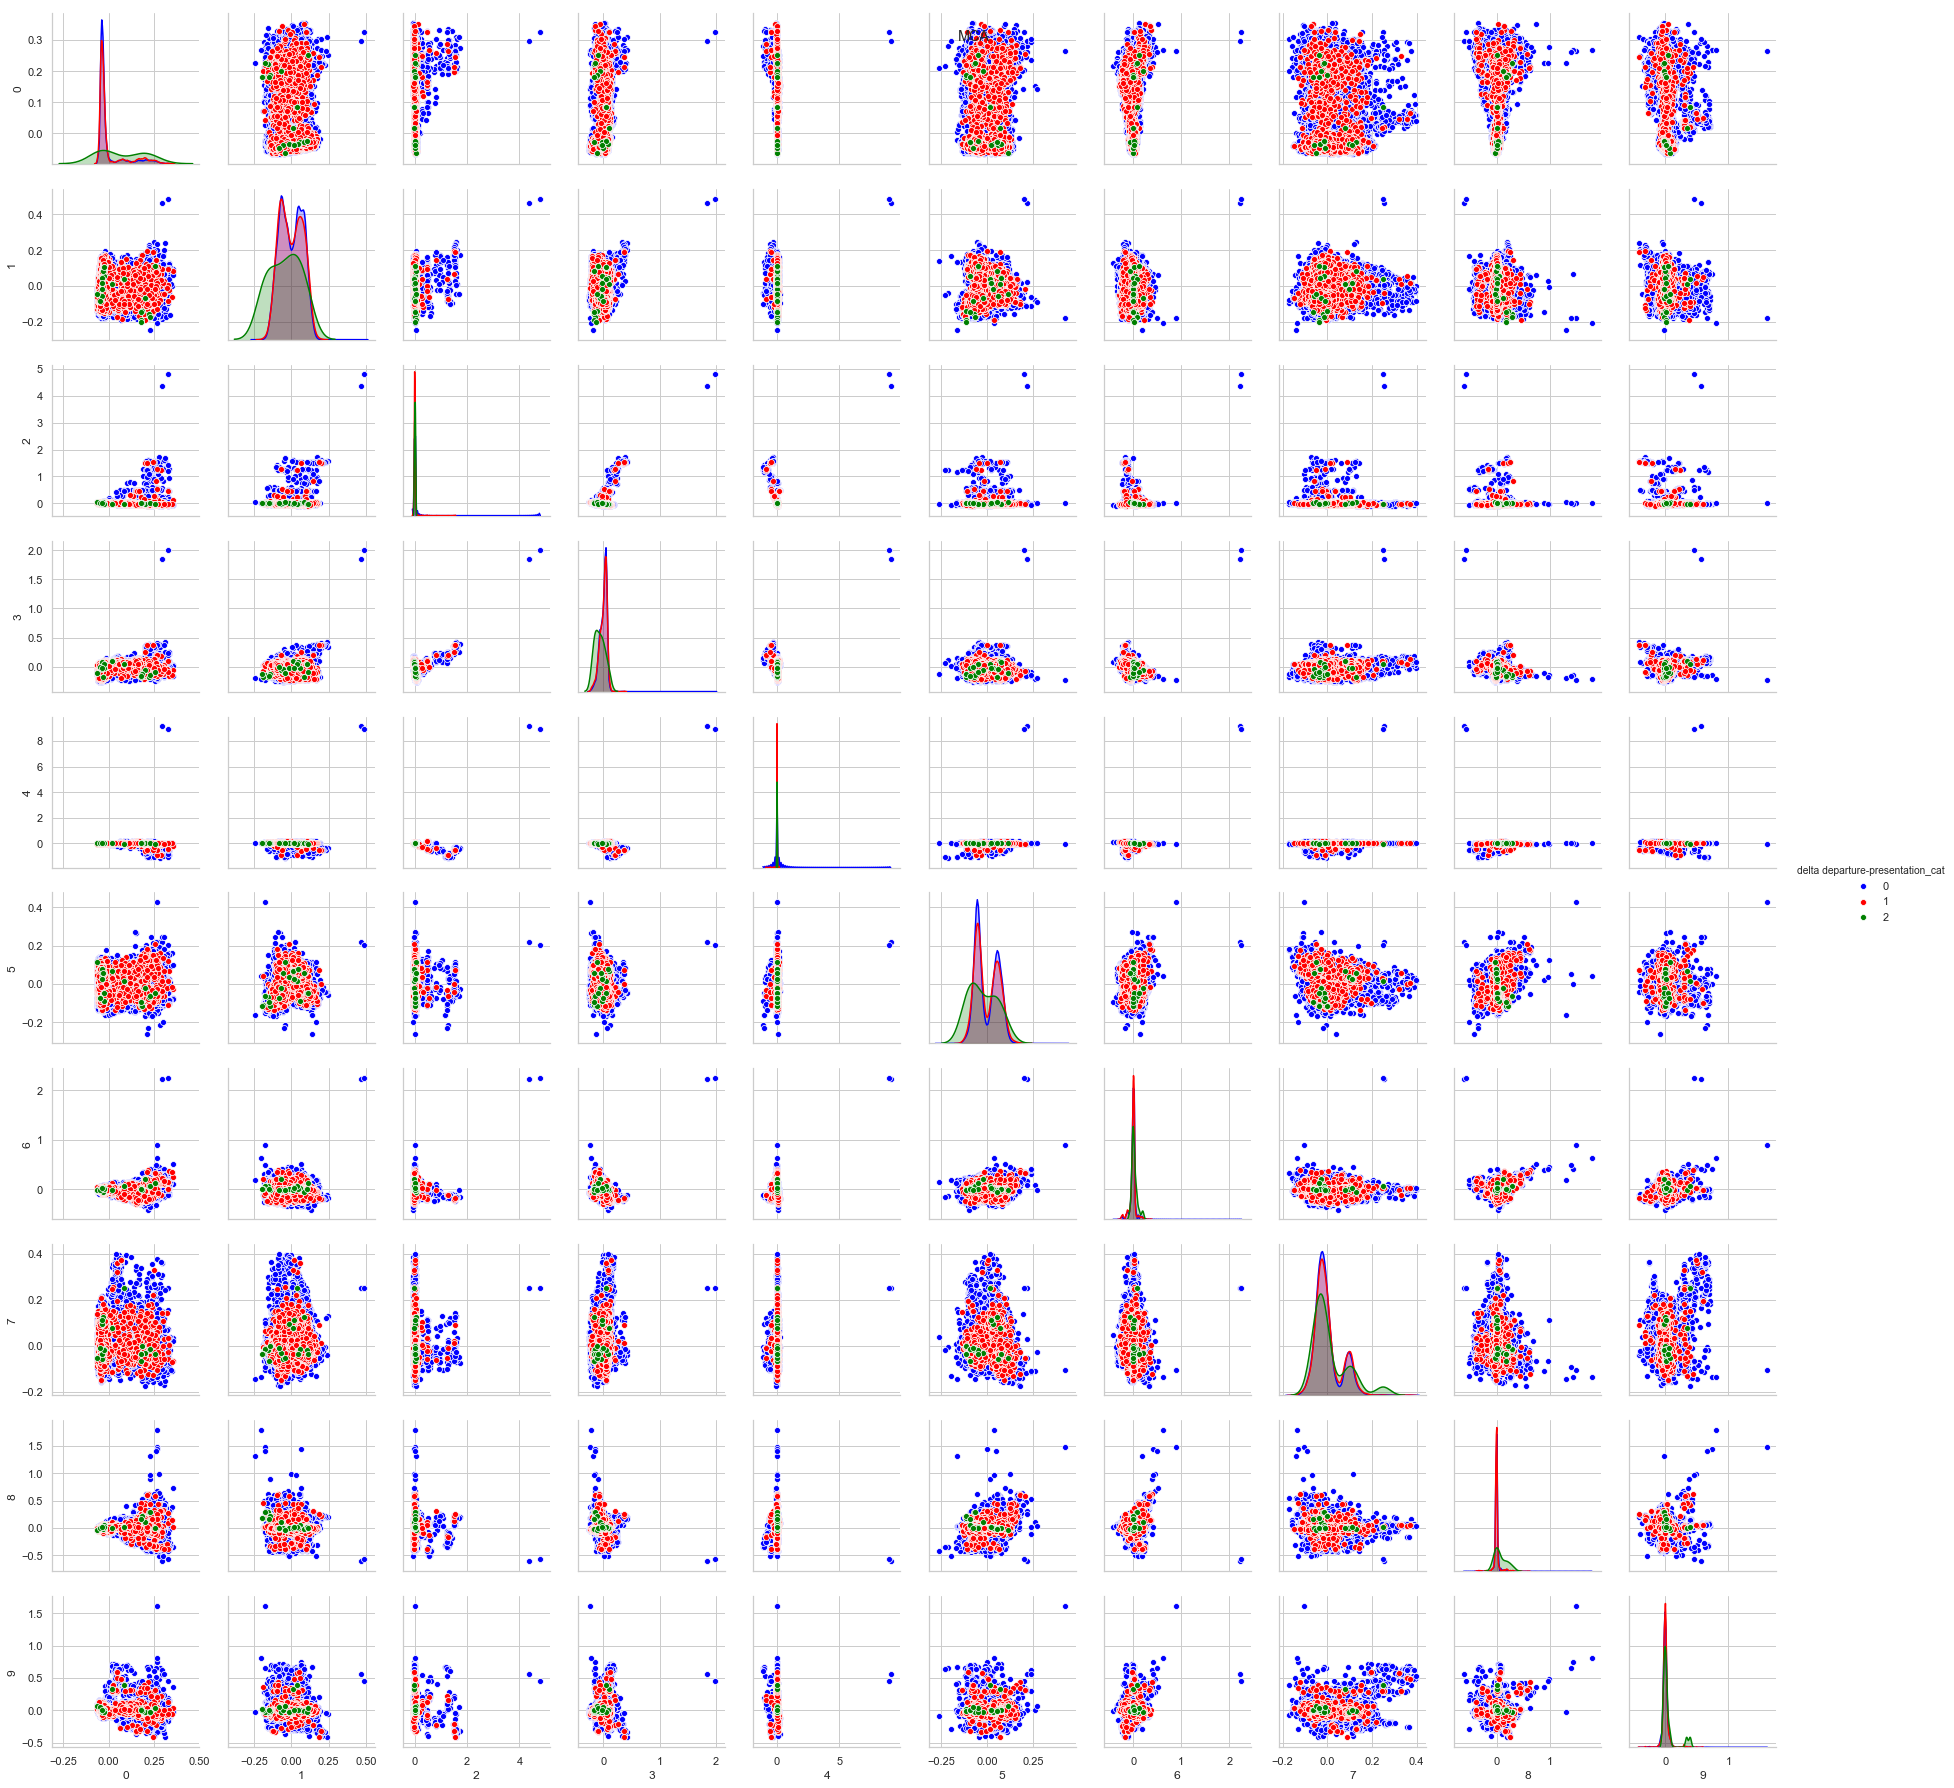

In [111]:
x_mca["delta departure-presentation_cat"] = data["delta departure-presentation_cat"]
g = sns.pairplot(x_mca, vars = x_mca.drop(columns = "delta departure-presentation_cat").columns,  hue = "delta departure-presentation_cat", palette = palette)
plt.suptitle("MCA");

MCA reduction allows to visualising the different groups.

In [112]:
data[["mca_"+str(k) for k in range(10)]]= x_mca.drop(columns = "delta departure-presentation_cat")

In [113]:
del x_mca, mca

##### FAMD

Factor Analysis for Mixed Data (FAMD) allows to reduce the dimensionality of numerical and categorical features but it is not using the categorical feature delta departure-presentation_cat. It requires the same assumptions as PCA.

In [173]:
#Normalise the numerical data 
x_famd = data[model_columns].copy()
x_famd[list(data[model_columns].select_dtypes(include=numerics).columns)]=normalize(x_famd[model_columns].select_dtypes(include=numerics))

In [174]:
famd = prince.FAMD(n_components=20,
...     n_iter=10)
famd.fit(x_famd)

FAMD(check_input=True, copy=True, engine='auto', n_components=20, n_iter=10,
     random_state=None)

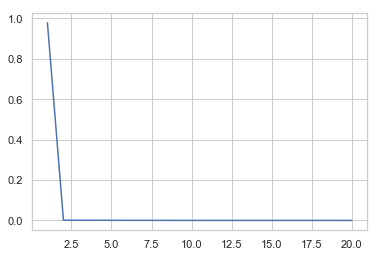

In [175]:
plt.plot(range(1,21),famd.explained_inertia_);

According to the elbow method, the best number of components for FAMD is 2.

In [176]:
x_famd = prince.FAMD(n_components=2,
...     n_iter=10).fit_transform(x_famd)

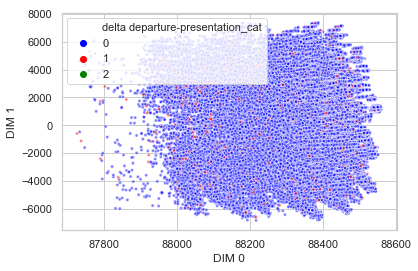

In [177]:
sns.scatterplot(x=x_famd[0], y = x_famd[1], hue =data["delta departure-presentation_cat"], palette ={0:"blue",1:"red",2:"green"}, alpha = 0.5, s=10 )
plt.xlabel("DIM 0")
plt.ylabel("DIM 1");

FAMD reduction doesn't allow visualising a clear split of the data in the different groups. Hence, FAMD will not be used.

In [178]:
data["famd_0"]= x_famd[0]
data["famd_1"]= x_famd[1]

In [179]:
del famd, x_famd

##### TSNE

T-distributed stochastic neighbor embedding (TSNE) allows visualising high-dimensional data converting similarities between data points to joint probabilities. 

In [180]:
#Normalise the numerical data 
x_tsne = data[["delta departure-presentation_cat"]+list(model_columns)].copy()
x_tsne[list(data[model_columns].select_dtypes(include=numerics).columns)]=normalize(x_tsne[model_columns].select_dtypes(include=numerics))

In [181]:
X_embedded = TSNE(n_components=2, perplexity = 100).fit_transform(x_tsne[["delta departure-presentation_cat"]+list(model_columns)])

In [182]:
i1=np.where(np.array(data["delta departure-presentation_cat"])==1)
i2=np.where(np.array(data["delta departure-presentation_cat"])==2)
i0=np.where(np.array(data["delta departure-presentation_cat"])==0)

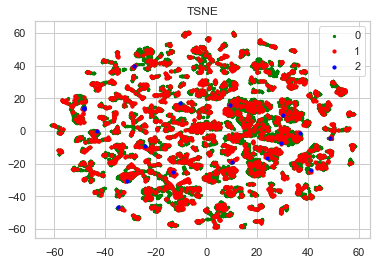

In [183]:
plt.scatter(X_embedded[i0,0],X_embedded[i0,1], color = "green", alpha = 1, s = 5)
plt.scatter(X_embedded[i1,0],X_embedded[i1,1], color = "red", alpha = 1, s = 10)
plt.scatter(X_embedded[i2,0],X_embedded[i2,1], color = "blue", alpha = 1, s = 10)

plt.title("TSNE")
plt.legend([0,1,2]);

TSNE reduction doesn't allow to visualise the different groups. Hence, TSNE will not be used.


In [184]:
del x_tsne,  X_embedded

### Clustering response times: K-means

K-means method is used to cluster the samples according to their *delta departure-presentation* group and the independent features. Kmeans using LDA features instead of the numerical features is compared to K-means with all the independent features.

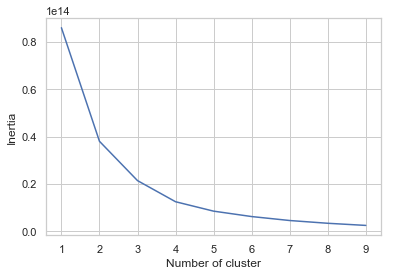

In [185]:
inertia = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data[["delta departure-presentation_cat"]+list(model_columns)])
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    inertia[k] = kmeans.inertia_ # Inertia
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

In [115]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data[["delta departure-presentation_cat"]+list(model_columns)])
data["k_means"] = kmeans.predict(data[["delta departure-presentation_cat"]+list(model_columns)])
data_visual["k_means"] = data["k_means"]

In [116]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data[["delta departure-presentation_cat","lda_0","lda_0"]+list(data[model_columns].select_dtypes(exclude=numerics).columns)])
data["k_means_lda"] = kmeans.predict(data[["delta departure-presentation_cat","lda_0","lda_0"]+list(data[model_columns].select_dtypes(exclude=numerics).columns)])
data_visual["k_means_lda"] = data["k_means_lda"]

In [117]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data[["delta departure-presentation_cat"]+["mca_"+str(k) for k in range(10)]+list(data[model_columns].select_dtypes(include=numerics).columns)])
data["k_means_mca"] = kmeans.predict(data[["delta departure-presentation_cat"]+["mca_"+str(k) for k in range(10)]+list(data[model_columns].select_dtypes(include=numerics).columns)])
data_visual["k_means_mca"] = data["k_means_mca"]

In [118]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data[["delta departure-presentation_cat","lda_0","lda_0"]+["mca_"+str(k) for k in range(10)]])
data["k_means_mca_lda"] = kmeans.predict(data[["delta departure-presentation_cat","lda_0","lda_0"]+["mca_"+str(k) for k in range(10)]])
data_visual["k_means_mca_lda"] = data["k_means_mca_lda"]

In [119]:
data.groupby(["k_means"])["delta departure-presentation_rat"].describe()

count      mean       std       min       25%       50%      75%  \
k_means                                                                       
0        58735.0  0.393212  0.482151 -1.805875  0.088879  0.342867  0.63708   
1          198.0  0.445516  0.479886 -0.924065  0.144099  0.446803  0.68739   
2         2582.0  0.461046  0.518792 -1.110661  0.159026  0.416564  0.69179   

              max  
k_means            
0        7.457802  
1        1.795008  
2        7.212786

In [120]:
data.groupby(["k_means_lda"])["delta departure-presentation_rat"].describe()

count      mean       std       min       25%       50%  \
k_means_lda                                                              
0             2242.0  0.383796  0.499142 -1.521387  0.068436  0.336396   
1             1559.0  0.406642  0.457653 -0.979266  0.113348  0.355140   
2            57714.0  0.396429  0.484017 -1.805875  0.091906  0.346436   

                  75%       max  
k_means_lda                      
0            0.633175  5.502458  
1            0.648456  3.404970  
2            0.639699  7.457802

In [121]:
data.groupby(["k_means_mca"])["delta departure-presentation_rat"].describe()

count      mean       std       min       25%       50%  \
k_means_mca                                                              
0            58735.0  0.393212  0.482151 -1.805875  0.088879  0.342867   
1             2582.0  0.461046  0.518792 -1.110661  0.159026  0.416564   
2              198.0  0.445516  0.479886 -0.924065  0.144099  0.446803   

                 75%       max  
k_means_mca                     
0            0.63708  7.457802  
1            0.69179  7.212786  
2            0.68739  1.795008

In [122]:
data.groupby(["k_means_mca_lda"])["delta departure-presentation_rat"].describe()

count      mean       std       min       25%       50%  \
k_means_mca_lda                                                              
0                 9445.0  0.140912  0.341270 -1.517323 -0.072269  0.131217   
1                47785.0  0.410718  0.457243 -1.805875  0.122240  0.371449   
2                 4285.0  0.797406  0.683304 -1.247990  0.380391  0.702280   

                      75%       max  
k_means_mca_lda                      
0                0.339774  1.949197  
1                0.652583  7.212786  
2                1.101190  7.457802

In [123]:
del kmeans

#### Assess the classification for generalisation

To choose between the two K-means clustering methods, a random forest classifier is used. Firstly, the data set is split in train (80%) and test (20%) and then the results are saved for the comparison.

In [124]:
r = pd.DataFrame()
conf_mat = []
for i in ["k_means_lda","k_means", "k_means_mca","k_means_mca_lda"]:
    Y = data[i]
    X = data[model_columns]
    xtrain, xtest, ytrain, ytest = train_test_split(X,Y, train_size = 0.8, test_size =0.2)
    RFC = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 50,min_samples_split= 5)
    results = RFC.fit(xtrain,ytrain)
    conf_mat = conf_mat + [confusion_matrix(ytest, RFC.predict(xtest))]
    r = pd.concat([r,pd.DataFrame({"Model":"RFC","OOB":RFC.oob_score_,"Test":RFC.score(xtest,ytest),"Train":RFC.score(xtrain,ytrain)}, index = [i])])
r

Model       OOB      Test     Train
k_means_lda       RFC  1.000000  1.000000  1.000000
k_means           RFC  0.996586  0.996342  0.999939
k_means_mca       RFC  0.996769  0.996749  0.999980
k_means_mca_lda   RFC  0.927762  0.930098  0.992299

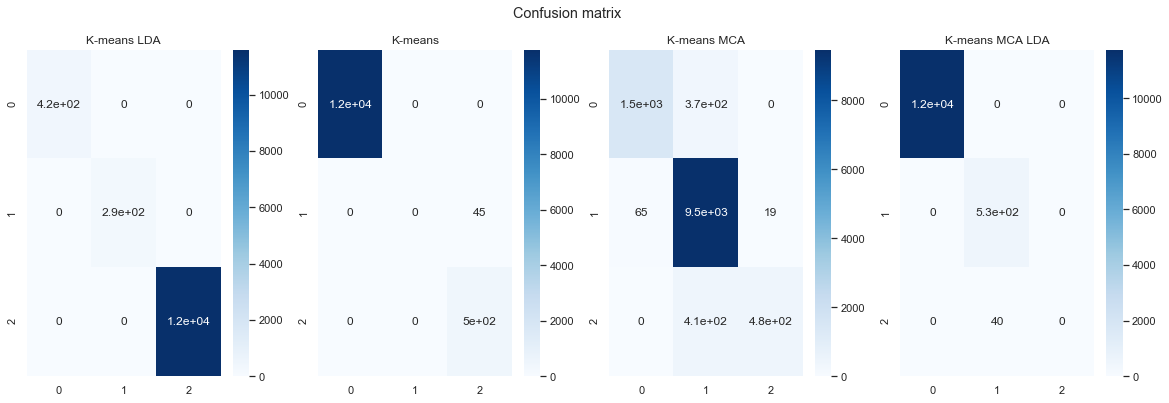

In [125]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,6))
sns.heatmap(conf_mat[0], annot=True, cmap = "Blues", ax =ax1);
ax1.set_title("K-means LDA")
sns.heatmap(conf_mat[1], annot=True, cmap = "Blues", ax =ax2);
ax2.set_title("K-means")
sns.heatmap(conf_mat[2], annot=True, cmap = "Blues", ax =ax4);
ax3.set_title("K-means MCA")
sns.heatmap(conf_mat[3], annot=True, cmap = "Blues", ax =ax3);
ax4.set_title("K-means MCA LDA")
plt.subplots_adjust( wspace = 0.2)
plt.suptitle("Confusion matrix");

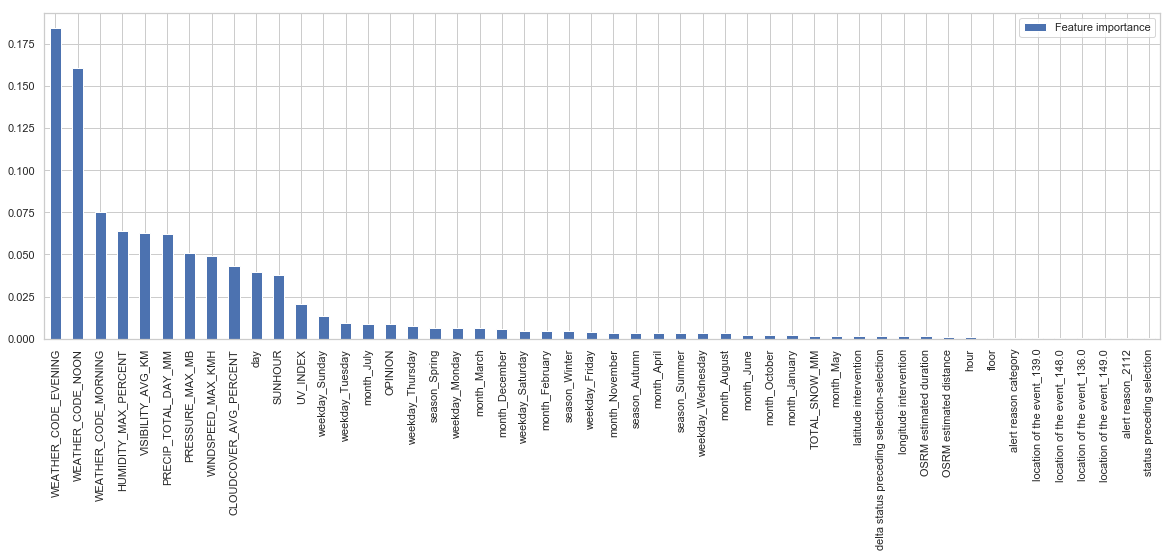

In [126]:
Y = data["k_means_lda"]
X = data[model_columns]
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, train_size = 0.8, test_size =0.2)
RFC = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 50,min_samples_split= 5)
RFC.fit(xtrain,ytrain)
pd.DataFrame(RFC.feature_importances_, index = xtrain.columns).sort_values(0, ascending = False).iloc[:50].plot.bar(figsize = (20,6));
plt.legend(["Feature importance"]);

The importance barplot highlights that the *WEATHER* and the *LDA* features are significant in the model.

#### Characteristics of the groups

> What is the difference between the groups of response times?

In [127]:
palette = dict(zip([0,1,2,3],["blue","red","green"]))

In [128]:
@interact
def show_hour(day=data_visual.weekday.sort_values().unique(), hour=data_visual.hour.sort_values().unique()):
    ax = IDF.plot( color = "None", edgecolor='black', figsize = (20, 10) )
    paris.plot( color = "None", edgecolor='black', ax = ax )
    Bspp.plot( color = "None", edgecolor ="grey", ax = ax)
    plot = data[(data.hour == hour) & (data["weekday_"+day]==1)]
    
    y = list(zip(plot["latitude before departure"], plot["latitude intervention"]))
    x = list(zip(plot["longitude before departure"], plot["longitude intervention"]))
    
    for i in range(0, len(x), 1):
        plt.plot(x[i], y[i], color = palette[plot.iloc[i,:]["k_means_lda"]])
    
    plt.xlim((2.1,2.65))
    plt.ylim((48.6,49.1))
    plt.title( "Emergency responses time by K-means LDA clusters" )
    plt.axis("off");

interactive(children=(Dropdown(description='day', options=('Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday…

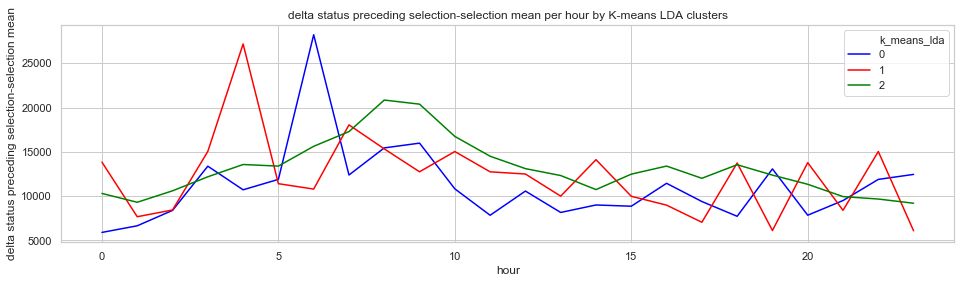

In [129]:
plt.figure( figsize = (16,4) )
sns.lineplot( x = "hour", y = "delta status preceding selection-selection",
              data = data.groupby( ["k_means_lda", "hour"] )["delta status preceding selection-selection"].mean( ).reset_index( ),
              hue = "k_means_lda",
              hue_order = data.groupby("k_means_lda")["delta status preceding selection-selection"].mean( ).sort_values( ).index,
              palette = palette)


plt.ylabel( "delta status preceding selection-selection mean" )
plt.title("delta status preceding selection-selection mean per hour by K-means LDA clusters");

The *delta status preceding selection-selection mean* in group 2 are higher on average than the ones in group 0 and 1.

In [131]:
table = ( data.groupby(["alert reason category","k_means_lda"]).size()/data.shape[0]*100 ).sort_values(ascending = False).reset_index()

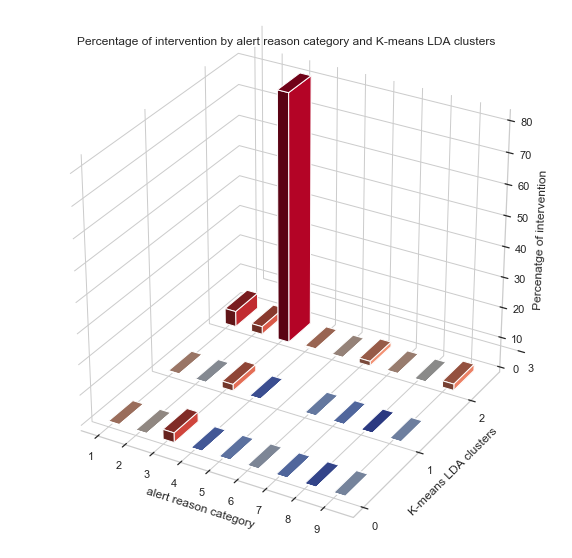

In [132]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
cmap = plt.cm.coolwarm
ax.bar3d(table["alert reason category"],table["k_means_lda"],0,0.4,0.4,table[0],color = list(map(cmap,table[0].rank()/table.shape[0])))
plt.yticks([0,1,2,3])
plt.xticks([1,2,3,4,5,6,7,8,9])
ax.set_zlabel( "Percenatge of intervention" )
plt.xlabel("alert reason category")
plt.ylabel("K-means LDA clusters")
plt.title("Percentage of intervention by alert reason category and K-means LDA clusters")
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0));

In [133]:
data_emergency_vehicle = data_visual.groupby( ["emergency vehicle type", "k_means_lda"] ).size()

In [134]:
data_emergency_vehicle.unstack(0).idxmax(1).replace({"PSE":"First Aid vehicles", "VSAV BSPP":"Aid and victims help vehicles", "VID":"Diverse interventions vehicles", "VLR BSPP":"Officer on duty vehicles"})

k_means_lda
0    Aid and victims help vehicles
1    Aid and victims help vehicles
2    Aid and victims help vehicles
dtype: object

In [135]:
data_emergency_vehicle.unstack(0)

emergency vehicle type     AR  BEAA BSPP   CA  CCR BSPP  CD BSPP  CRAC  \
k_means_lda                                                              
0                        10.0        NaN  NaN       8.0      NaN   NaN   
1                        13.0        2.0  NaN       8.0      NaN   NaN   
2                       389.0       85.0  1.0     198.0      9.0   2.0   

emergency vehicle type  EPA BSPP   EPAN   EPSA     FA  FMOGP BSPP  FPT BSPP  \
k_means_lda                                                                   
0                            7.0   15.0    5.0   15.0         NaN      32.0   
1                           11.0    9.0    2.0   11.0         NaN      34.0   
2                          296.0  272.0  129.0  462.0         1.0     788.0   

emergency vehicle type  FPTL BSPP     PSE  PST   VID  VLR BSPP   VPS  VRA  \
k_means_lda                                                                 
0                             1.0   154.0  NaN   5.0      47.0   NaN  NaN   
1                             4.0   124.0  NaN   2.0      37.0   NaN  NaN   
2                            72.0  5043.0  7.0  77.0    1319.0  12.0  2.0   

emergency vehicle type  VSAV BSPP  
k_means_lda                        
0                          1943.0  
1                          1302.0  
2                         48550.0

In [136]:
data.groupby("k_means_lda")["CLOUDCOVER_AVG_PERCENT"].describe()

count       mean        std   min     25%     50%     75%  \
k_means_lda                                                                
0             2242.0  42.992250  24.499784  12.0  25.125  35.375  62.250   
1             1559.0  68.565346  21.372428  31.5  43.750  71.625  90.375   
2            57714.0  45.406600  28.673740   0.0  20.250  43.000  69.500   

                 max  
k_means_lda           
0             97.125  
1             93.500  
2            100.000

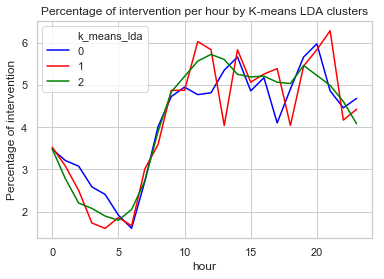

In [137]:
data_hour = data.groupby(["k_means_lda","hour"]).size().reset_index(1)
data_hour[0]=data_hour.groupby("k_means_lda")[0].apply(lambda x : x/sum(x)*100)
sns.lineplot(data = data_hour.reset_index(), x = "hour", y = 0, hue = "k_means_lda", palette = palette)
plt.ylabel("Percentage of intervention")
plt.title("Percentage of intervention per hour by K-means LDA clusters");

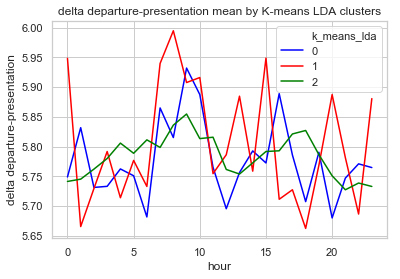

In [153]:
data_hour = data.groupby(["k_means_lda","hour"])["delta departure-presentation"].mean().reset_index()
sns.lineplot(data = data_hour, x = "hour", y = "delta departure-presentation", hue = "k_means_lda", palette = palette)
plt.title("delta departure-presentation mean by K-means LDA clusters");

### Modelling the response times: Linear Regression

> What influences the response times of each group of response times?

In [139]:
model_columns = ["lda_0","lda_1"]+list(data[model_columns].select_dtypes(exclude=numerics).columns)

In [140]:
import statsmodels.api as sm

In [141]:
results = pd.DataFrame()
for group in data["k_means_lda"].unique():
    select = data[data.k_means_lda == group].copy()
    select.dropna(inplace = True)
    X = np.asarray(select[model_columns].astype("int"))
    y = np.asarray(select["delta departure-presentation"])
    ols = sm.OLS(y,X)
    r = ols.fit()
    results[group]=np.asarray(r.pvalues)
results["Features"]=list(model_columns)
results = results.set_index("Features")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Asus\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Asus\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Asus\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The features with a p-value of more than 0.5 are not statically significant.

In [142]:
results_significant = results[results<0.5].sort_values(2).dropna( how = "all")

In [143]:
results_significant.shape[0]

702

In [144]:
results_significant.loc[[col for col in data.columns if "weekday" in col]]

2             0             1
Features                                          
weekday_Friday     0.0           NaN  3.964680e-11
weekday_Monday     0.0  8.413528e-02  1.307221e-31
weekday_Saturday   0.0           NaN  9.923149e-44
weekday_Sunday     0.0  4.103644e-07  6.631049e-04
weekday_Thursday   0.0  5.375130e-02  1.958028e-52
weekday_Tuesday    0.0  1.624519e-02           NaN
weekday_Wednesday  0.0           NaN  8.323692e-02

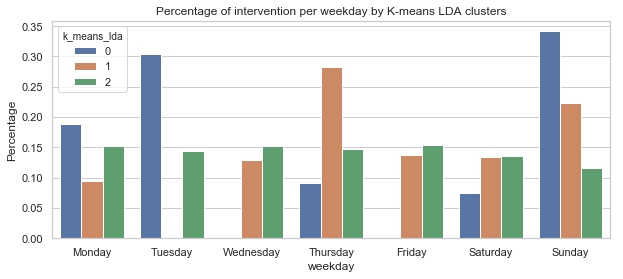

In [145]:
plt.figure(figsize = (10,4))
sns.barplot(x= "weekday",y="Percentage", hue ="k_means_lda",data = data_visual.groupby(["k_means_lda"]).weekday.value_counts(normalize=True).rename('Percentage').reset_index(), order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"] )
plt.title("Percentage of intervention per weekday by K-means LDA clusters");

In [146]:
results_significant.loc[[col for col in data.columns if "month" in col]]

2         0             1
Features                                   
month_April     0.0       NaN           NaN
month_August    0.0  0.039169           NaN
month_December  0.0  0.000029  9.164107e-63
month_February  0.0       NaN  4.670143e-52
month_January   0.0       NaN           NaN
month_July      0.0  0.032295  9.499049e-85
month_June      0.0       NaN           NaN
month_March     0.0  0.001059  8.323692e-02
month_May       0.0  0.177976           NaN
month_November  0.0       NaN  1.073878e-45
month_October   0.0  0.053751           NaN

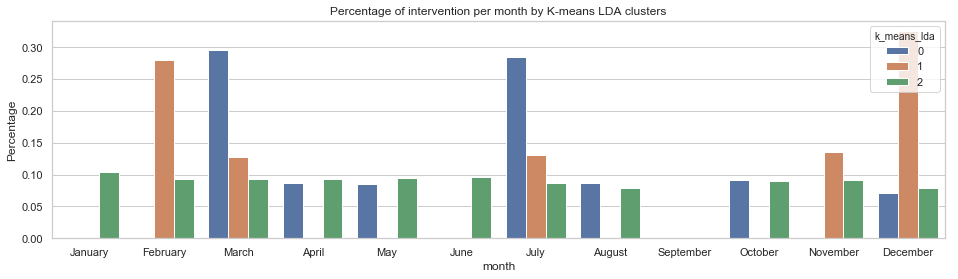

In [147]:
plt.figure(figsize = (16,4))
sns.barplot(x= "month",y="Percentage", hue ="k_means_lda",data = data_visual.groupby(["k_means_lda"]).month.value_counts(normalize=True).rename('Percentage').reset_index(), order = ["January","February","March","April","May","June","July","August","September","October","November","December"])
plt.title("Percentage of intervention per month by K-means LDA clusters");

In [148]:
results_significant.loc[[col for col in weather.columns if col in results_significant.index]]

2             0             1
Features                                                  
WEATHER_CODE_MORNING       NaN  3.090073e-05  4.393488e-88
WEATHER_CODE_NOON     0.030167  1.285503e-62  3.501441e-13
WEATHER_CODE_EVENING       NaN  4.266167e-02  3.698660e-90
UV_INDEX              0.034434  2.564750e-01  4.303074e-46
OPINION               0.370297  3.434234e-01  4.041873e-32

In [149]:
results_significant.loc[[col for col in results_significant.index if "emergency" in col]]

2         0         1
Features                                                          
emergency vehicle type_VSAV BSPP  2.156231e-54       NaN       NaN
emergency vehicle type_PSE        5.596573e-54       NaN       NaN
emergency vehicle type_VLR BSPP   6.647439e-47       NaN  0.380638
emergency vehicle type_FPT BSPP   9.029346e-46       NaN       NaN
emergency vehicle type_EPA BSPP   5.916448e-22       NaN       NaN
emergency vehicle type_FA         3.512483e-21       NaN       NaN
emergency vehicle type_EPAN       7.752002e-21       NaN  0.151541
emergency vehicle type_VID        9.302638e-19  0.342037  0.397221
emergency vehicle type_EPSA       4.923991e-16       NaN  0.398627
emergency vehicle type_VPS        1.029866e-11       NaN       NaN
emergency vehicle type_FPTL BSPP  8.936501e-10  0.420484  0.474804
emergency vehicle type_BEAA BSPP  5.662025e-09       NaN       NaN
emergency vehicle type_AR         2.927295e-08       NaN       NaN
emergency vehicle_1867            8.545632e-06  0.082763  0.067952
emergency vehicle type_PST        8.545632e-06       NaN       NaN
emergency vehicle_4461            1.542604e-05  0.190869  0.048632
emergency vehicle type_CCR BSPP   1.625474e-05  0.444297  0.462858
emergency vehicle_3107            1.732380e-05  0.358069  0.344468
emergency vehicle type_VRA        2.963238e-05       NaN       NaN
emergency vehicle_4510            5.542264e-05  0.371283  0.075213
emergency vehicle_2526            1.410098e-04  0.234752  0.251863
emergency vehicle_5966            8.076116e-04       NaN  0.270931
emergency vehicle_3530            4.334970e-03       NaN       NaN
emergency vehicle_3093            4.571816e-03       NaN  0.274681
emergency vehicle type_CD BSPP    4.832833e-03       NaN       NaN
emergency vehicle_2583            4.963310e-03  0.001607  0.399872
emergency vehicle_5728            1.044188e-02       NaN  0.330254
emergency vehicle_3063            1.063230e-02  0.176124  0.023106
emergency vehicle_4509            1.162528e-02       NaN       NaN
emergency vehicle_6042            1.243947e-02  0.285676       NaN
...                                        ...       ...       ...
emergency vehicle_4537                     NaN  0.052600       NaN
emergency vehicle_4539                     NaN  0.335727       NaN
emergency vehicle_4545                     NaN  0.000592  0.073178
emergency vehicle_4546                     NaN  0.469245       NaN
emergency vehicle_4871                     NaN  0.141683  0.241087
emergency vehicle_4872                     NaN       NaN  0.411265
emergency vehicle_4874                     NaN  0.355798  0.012222
emergency vehicle_4875                     NaN  0.139589       NaN
emergency vehicle_4878                     NaN  0.345559  0.444184
emergency vehicle_4879                     NaN  0.009225       NaN
emergency vehicle_4891                     NaN  0.066535  0.040375
emergency vehicle_4903                     NaN       NaN  0.389804
emergency vehicle_4904                     NaN       NaN  0.004610
emergency vehicle_5670                     NaN       NaN  0.150049
emergency vehicle_5683                     NaN       NaN  0.286738
emergency vehicle_5685                     NaN  0.411070       NaN
emergency vehicle_5703                     NaN       NaN  0.075799
emergency vehicle_5720                     NaN  0.075961  0.066169
emergency vehicle_5725                     NaN  0.339775       NaN
emergency vehicle_5731                     NaN  0.264994       NaN
emergency vehicle_5734                     NaN       NaN  0.479915
emergency vehicle_5742                     NaN  0.063159  0.475240
emergency vehicle_5746                     NaN  0.290847       NaN
emergency vehicle_5758                     NaN  0.224496  0.452740
emergency vehicle_5765                     NaN       NaN  0.074108
emergency vehicle_5783                     NaN  0.095184       NaN
emergency vehicle_5787                     NaN  0.146463       NaN
emergency vehicle_5823   

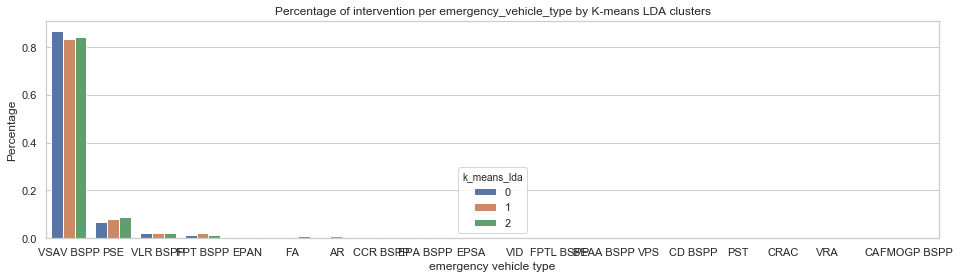

In [150]:
plt.figure(figsize = (16,4))
sns.barplot(x= "emergency vehicle type",y="Percentage", hue ="k_means_lda",data = data_visual.groupby(["k_means_lda"])["emergency vehicle type"].value_counts(normalize=True).rename('Percentage').reset_index())
plt.title("Percentage of intervention per emergency_vehicle_type by K-means LDA clusters");

In [151]:
results_significant.loc[[col for col in results_significant.index if "location" in col]]

2         0         1
Features                                                     
location of the event_325.0  2.390025e-09  0.005035       NaN
location of the event_299.0  1.342466e-05       NaN       NaN
location of the event_140.0  3.263422e-05       NaN       NaN
location of the event_169.0  5.502250e-05  0.068535       NaN
location of the event_136.0  6.364761e-04       NaN  0.073965
location of the event_241.0  6.484410e-04  0.437880  0.470906
location of the event_139.0  6.604190e-04  0.344200  0.017044
location of the event_322.0  2.080528e-03  0.029297  0.406825
location of the event_323.0  2.467161e-03  0.117236       NaN
location of the event_226.0  2.598180e-03       NaN       NaN
location of the event_219.0  4.974124e-03       NaN  0.250357
location of the event_233.0  6.638410e-03       NaN  0.257521
location of the event_147.0  6.791000e-03       NaN  0.177612
location of the event_202.0  9.452415e-03       NaN       NaN
location of the event_242.0  1.064462e-02       NaN  0.351189
location of the event_157.0  1.926931e-02       NaN       NaN
location of the event_104.0  1.977820e-02  0.461575  0.026024
location of the event_211.0  2.111178e-02       NaN  0.497049
location of the event_321.0  2.608872e-02  0.333939       NaN
location of the event_141.0  2.955088e-02  0.131163       NaN
location of the event_171.0  4.027762e-02       NaN       NaN
location of the event_204.0  4.063029e-02  0.052154       NaN
location of the event_164.0  4.079270e-02  0.253286       NaN
location of the event_134.0  4.247574e-02       NaN       NaN
location of the event_255.0  4.448565e-02       NaN       NaN
location of the event_218.0  4.471266e-02       NaN  0.175152
location of the event_184.0  4.662992e-02       NaN       NaN
location of the event_124.0  4.742926e-02       NaN       NaN
location of the event_275.0  5.183378e-02       NaN       NaN
location of the event_156.0  5.513498e-02       NaN       NaN
...                                   ...       ...       ...
location of the event_168.0  4.181670e-01       NaN       NaN
location of the event_154.0  4.206562e-01       NaN       NaN
location of the event_195.0  4.252084e-01       NaN       NaN
location of the event_250.0  4.451975e-01       NaN       NaN
location of the event_286.0  4.501284e-01  0.480426  0.128443
location of the event_274.0  4.556967e-01       NaN  0.041059
location of the event_155.0  4.668875e-01       NaN       NaN
location of the event_187.0  4.720842e-01       NaN       NaN
location of the event_150.0  4.802023e-01       NaN       NaN
location of the event_189.0  4.893307e-01       NaN       NaN
location of the event_103.0           NaN  0.463082       NaN
location of the event_106.0           NaN  0.230392  0.155751
location of the event_108.0           NaN       NaN  0.173494
location of the event_111.0           NaN  0.196901       NaN
location of the event_143.0           NaN  0.442075  0.210304
location of the event_146.0           NaN       NaN  0.471102
location of the event_148.0           NaN  0.404860  0.444235
location of the event_165.0           NaN       NaN  0.024272
location of the event_179.0           NaN       NaN  0.415827
location of the event_196.0           NaN  0.073740  0.158890
location of the event_199.0           NaN       NaN  0.187907
location of the event_203.0           NaN       NaN  0.430265
location of the event_208.0           NaN       NaN  0.301246
location of the event_212.0           NaN       NaN  0.209707
location of the event_222.0           NaN  0.478535       NaN
location of the event_224.0           NaN  0.430094  0.206978
location of the event_227.0           NaN       NaN  0.411124
location of the event_235.0           NaN       NaN  0.337343
location of the event_260.0           NaN  0.443639       NaN
location of the event_264.0           NaN  0.489133  0.348296

[136 rows x 3 columns]

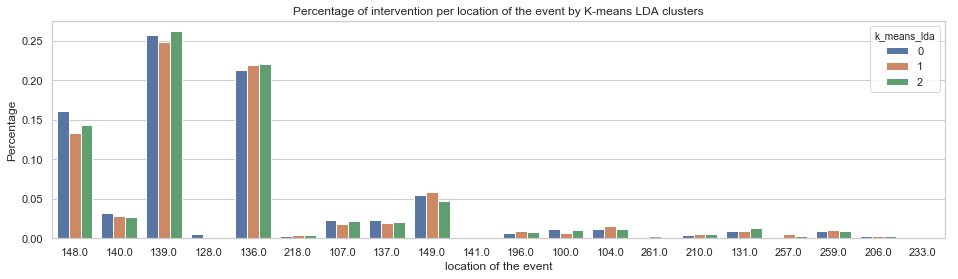

In [152]:
plt.figure(figsize = (16,4))
sns.barplot(x= "location of the event",y="Percentage", hue ="k_means_lda",data = data_visual.groupby(["k_means_lda"])["location of the event"].value_counts(normalize=True).rename('Percentage').sort_values(ascending = False).reset_index(), order = data_visual["location of the event"].unique()[:20])
plt.title("Percentage of intervention per location of the event by K-means LDA clusters");

## References

[1] Paris Fire Brigade, “Challenge,” Github.io, 2019. [Online]. Available: https://paris-fire-brigade.github.io/data-challenge/challenge.html. [Accessed: 22-Oct-2019] 

[2] T. Samson, "Météo à Paris", Historique Météo, 2019. [Online]. Available: https://www.historique-meteo.net/france/ile-de-france/paris/. [Accessed: 02- Dec- 2019].

[3] "Liste des casernes à Paris et dans les départements de la petite couronne", Data.gouv.fr, 2019. [Online]. Available: https://www.data.gouv.fr/fr/datasets/liste-des-casernes-a-paris-et-dans-les-departements-de-la-petite-couronne-551678/#_. [Accessed: 03- Dec- 2019].

[4] "Les communes d'Île-de-France", Data.gouv.fr, 2019. [Online]. Available: https://www.data.gouv.fr/fr/datasets/les-communes-d-ile-de-france-idf/. [Accessed: 03- Dec- 2019].

[5]"Arrondissements", Data.gouv.fr, 2019. [Online]. Available: https://www.data.gouv.fr/fr/datasets/arrondissements-1/. [Accessed: 03- Dec- 2019].

[6] "Données communales sur la population d'Île-de-France", Data.gouv.fr, 2019. [Online]. Available: https://www.data.gouv.fr/fr/datasets/donnees-communales-sur-la-population-d-ile-de-france-idf/#_. [Accessed: 03- Dec- 2019].

[7]  "Les engins", Pompiersparis.fr, 2019. [Online]. Available: https://www.pompiersparis.fr/fr/operationnelle/engin. [Accessed: 30- Oct- 2019].

[8] M. Halford, "Prince", GitHub, 2019. [Online]. Available: https://github.com/MaxHalford/prince. [Accessed: 03- Dec- 2019].

[9] M. Wattenberg, F. Viégas, and I. Johnson, “How to Use t-SNE Effectively,” Distill, vol. 1, no. 10, Oct. 2016.

[10] Ş. Büyüköztürk and Ö. Çokluk-Bökeoğlu, “Discriminant Function Analysis: Concept and Application,” Eurasian Journal of Educational Research, vol. 33, pp. 73–92, 2008.
